<a href="https://colab.research.google.com/github/vicentbas/ia3_uv/blob/main/ecg_full_dataframe_kaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![IDAL](https://i.imgur.com/tIKXIG1.jpg)  

#**Máster en Inteligencia Artificial Avanzada y Aplicada:  IA^3**
---
# Trabajo evaluación bloque 2: Clasificador de electrocardiogramas mediante LSTM

#<strong><center> ECG analyzer </strong>

El objetivo del siguiente proyecto es crear un clasificador de electrocardiogramas, capaz de diferencias entre estudios patológicos y estudios normales. Como entrada al proyecto se utilzan ficheros XML exportados desde el sistema Philips IntelliSpace ECG B.00.02 en formato XML FDA para electrocardiografos de 12 derivaciones.

VERSIÓN DATASET KAGGLE: https://www.kaggle.com/khyeh0719/ptb-xl-dataset

In [ ]:
from xml.dom import minidom
from os import listdir
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
 
from keras.models import Sequential, Model, load_model
from keras.layers import LSTM, Dense, Input, Concatenate, GlobalMaxPooling1D, BatchNormalization, Activation, TimeDistributed, Conv1D, MaxPooling1D, Dropout, LeakyReLU, GlobalAveragePooling1D, Flatten, ReLU
from keras.optimizers import Adam
from tensorflow import keras
 
import glob
import re
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import scipy.io
import json 
 
np.random.seed(7)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
ruta_base = "/content/drive/MyDrive/Kaggle/ptb-ecg/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install wfdb wget

In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
def equalizer(Y):
  #'CD', 'HYP', 'MI', 'NORM', 'STTC'
  CD = Y[Y['diagnostic_superclass'] == 'CD'].count()['diagnostic_superclass']
  HYP = Y[Y['diagnostic_superclass'] == 'HYP'].count()['diagnostic_superclass']
  MI = Y[Y['diagnostic_superclass'] == 'MI'].count()['diagnostic_superclass']
  NORM = Y[Y['diagnostic_superclass'] == 'NORM'].count()['diagnostic_superclass']
  STTC = Y[Y['diagnostic_superclass'] == 'STTC'].count()['diagnostic_superclass']
  min = int(np.mean(np.array([CD,HYP,MI,NORM,STTC])))
 
  t1 = Y[Y['diagnostic_superclass'] == 'CD'][:min]
  t2 = Y[Y['diagnostic_superclass'] == 'HYP'][:min]
  t3 = Y[Y['diagnostic_superclass'] == 'MI'][:min]
  t4 = Y[Y['diagnostic_superclass'] == 'NORM'][:min]
  t5 = Y[Y['diagnostic_superclass'] == 'STTC'][:min]
 
  return pd.concat([t1, t2, t3, t4, t5], ignore_index=True)

In [ ]:
import ast
import wfdb
path = ruta_base
sampling_rate=500
input_size=sampling_rate * 10
n_muestras = 10000
 
# load and convert annotation data
Y = pd.read_csv(path+'ptbxl_database.csv', index_col='ecg_id', nrows=n_muestras)
Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))
 
# Load scp_statements.csv for diagnostic aggregation
agg_df = pd.read_csv(path+'scp_statements.csv', index_col=0)
agg_df = agg_df[agg_df.diagnostic == 1]
 
def aggregate_diagnostic(y_dic):
    tmp = ""
    for key in y_dic.keys():
        if key in agg_df.index:
            tmp = agg_df.loc[key].diagnostic_class
            break
    return tmp
 
Y['diagnostic_superclass'] = Y.scp_codes.apply(aggregate_diagnostic)
 
Y = Y[Y['diagnostic_superclass'] != '']
 
Y = equalizer(Y)
 
y = np.array(Y.diagnostic_superclass)

In [ ]:
if sampling_rate == 100:
    data = [wfdb.rdsamp(path+f) for f in Y.filename_lr]
else:
    data = [wfdb.rdsamp(path+f) for f in Y.filename_hr]
data = np.array([signal for signal, meta in data])
 
X = data
 
del data

# Ploting sample leads

In [ ]:
scalers = {}
for i in range(X.shape[0]):
  scalers[i] = preprocessing.MinMaxScaler()
  X[i,:,:]  = scalers[i].fit_transform(X[i,:,:])

In [ ]:
derv_1 = X[:,:,0].reshape(len(y), 5000,1)
derv_2 = X[:,:,1].reshape(len(y), 5000,1)
derv_3 = X[:,:,2].reshape(len(y), 5000,1)
derv_4 = X[:,:,3].reshape(len(y), 5000,1)
derv_5 = X[:,:,4].reshape(len(y), 5000,1)
derv_6 = X[:,:,5].reshape(len(y), 5000,1)
derv_7 = X[:,:,6].reshape(len(y), 5000,1)
derv_8 = X[:,:,7].reshape(len(y), 5000,1)
derv_9 = X[:,:,8].reshape(len(y), 5000,1)
derv_10 = X[:,:,9].reshape(len(y), 5000,1)
derv_11 = X[:,:,10].reshape(len(y), 5000,1)
derv_12 = X[:,:,11].reshape(len(y), 5000,1)

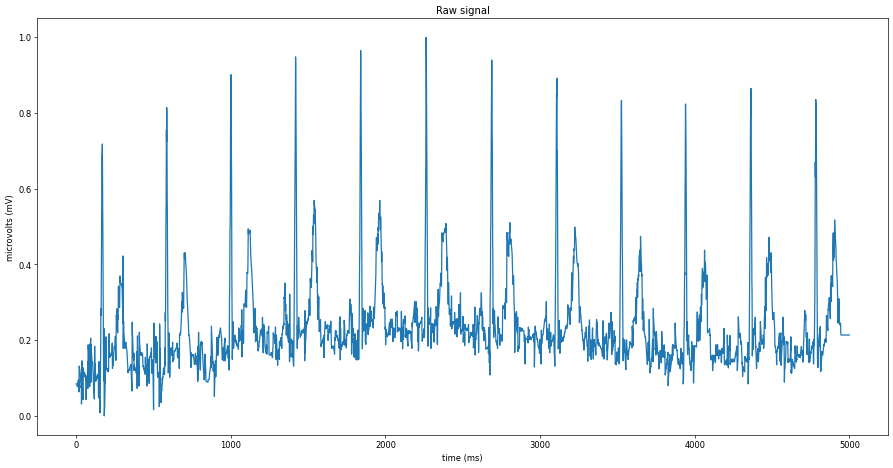

In [ ]:
plt.figure(figsize=(15,15), dpi= 60)
plt.subplot(2, 1, 1)
plt.plot(derv_1[5,:])
plt.xlabel('time (ms)')
plt.ylabel('microvolts (mV)')
plt.title("Raw signal")
plt.tight_layout()
plt.show()

In [ ]:
le = preprocessing.LabelEncoder()
le.fit(y)
y_ = le.transform(y)
from keras.utils import np_utils
uniques, ids = np.unique(y_, return_inverse=True)
y_ = np_utils.to_categorical(ids, len(uniques))

In [ ]:
def reverse_transform(array_val):
  return le.inverse_transform(uniques[array_val.argmax(1)])

In [ ]:
np.unique(y, return_counts=True)

(array(['CD', 'HYP', 'MI', 'NORM', 'STTC'], dtype=object),
 array([1017,  585, 1973, 1973, 1314]))

In [ ]:
categories = len(np.unique(y))

In [ ]:
def generate_model_1(dervicaciones, epochs, X_train, X_test, Y_train, Y_test, lr):

  input = Input((input_size,dervicaciones))
  ecg_model = Conv1D(64,kernel_size=20)(input)
  ecg_model = MaxPooling1D(pool_size=2)(ecg_model)
  ecg_model = Conv1D(128,kernel_size=16)(ecg_model)
  ecg_model = MaxPooling1D(pool_size=2)(ecg_model)
  ecg_model = Conv1D(256,kernel_size=8)(ecg_model)
  ecg_model = MaxPooling1D(pool_size=2)(ecg_model)
  ecg_model = Conv1D(512,kernel_size=4)(ecg_model)
  ecg_model = MaxPooling1D(pool_size=2)(ecg_model)
  ecg_model = Conv1D(256,kernel_size=8)(ecg_model)
  ecg_model = MaxPooling1D(pool_size=2)(ecg_model)
  ecg_model = LSTM(128,  go_backwards=True, return_sequences=True)(ecg_model)
  ecg_model = LSTM(128, return_sequences=True)(ecg_model)
  ecg_model = Flatten()(ecg_model)
  ecg_model = Dense(64, activation='relu')(ecg_model)
  o  = Dense(categories, activation='softmax')(ecg_model)
  
  model = Model(inputs = input, outputs = o)

  opt = Adam(lr=lr)
  model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=["accuracy"])

  history = model.fit(X_train,y_train, epochs=epochs,verbose=0, validation_data=(X_test,y_test))

  return model, history

In [ ]:
def generate_model_2(dervicaciones, epochs, X_train, X_test, Y_train, Y_test, lr):

  input = Input((input_size,dervicaciones))
  ecg_model = Conv1D(64,kernel_size=21,strides=11)(input)
  ecg_model = MaxPooling1D(pool_size=2)(ecg_model)
  ecg_model = BatchNormalization()(ecg_model)
  ecg_model = LeakyReLU(alpha=0.1)(ecg_model)
  ecg_model = Dropout(rate=0.3)(ecg_model)
  ecg_model = Conv1D(64,kernel_size=7,strides=1)(ecg_model)
  ecg_model = MaxPooling1D(pool_size=2)(ecg_model)
  ecg_model = BatchNormalization()(ecg_model)
  ecg_model = Conv1D(128,kernel_size=5,strides=1)(ecg_model)
  ecg_model = MaxPooling1D(pool_size=2)(ecg_model)
  ecg_model = Conv1D(256,kernel_size=13,strides=1)(ecg_model)
  ecg_model = Conv1D(512,kernel_size=7,strides=1)(ecg_model)
  ecg_model = Dropout(rate=0.3)(ecg_model)
  ecg_model = Conv1D(256,kernel_size=9,strides=1)(ecg_model)
  ecg_model = MaxPooling1D(pool_size=2)(ecg_model)
  ecg_model = LSTM(128, return_sequences=True)(ecg_model)
  ecg_model = Flatten()(ecg_model)
  ecg_model = Dense(64, activation='relu')(ecg_model)
  o  = Dense(categories, activation='softmax')(ecg_model)
  
  model = Model(inputs = input, outputs = o)

  opt = Adam(lr=lr)
  model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=["accuracy"])

  history = model.fit(X_train,y_train, epochs=epochs,verbose=0, validation_data=(X_test,y_test))

  return model, history

In [ ]:
def generate_model_3(dervicaciones, epochs, X_train, X_test, Y_train, Y_test, lr):

  input = Input((input_size,dervicaciones))
  ecg_model = Conv1D(64,kernel_size=20)(input)
  ecg_model = MaxPooling1D(pool_size=2)(ecg_model)
  ecg_model = Conv1D(128,kernel_size=16)(ecg_model)
  ecg_model = MaxPooling1D(pool_size=2)(ecg_model)
  ecg_model = Conv1D(256,kernel_size=8)(ecg_model)
  ecg_model = MaxPooling1D(pool_size=2)(ecg_model)
  ecg_model = Conv1D(512,kernel_size=4)(ecg_model)
  ecg_model = MaxPooling1D(pool_size=2)(ecg_model)
  ecg_model = Conv1D(256,kernel_size=8)(ecg_model)
  ecg_model = MaxPooling1D(pool_size=2)(ecg_model)
  ecg_model = LSTM(128,  go_backwards=True, return_sequences=True)(ecg_model)
  ecg_model = LSTM(128, go_backwards=True, return_sequences=True)(ecg_model)
  ecg_model = LSTM(128,  go_backwards=True, return_sequences=True)(ecg_model)
  ecg_model = LSTM(128, go_backwards=True, return_sequences=True)(ecg_model)
  ecg_model = Flatten()(ecg_model)
  ecg_model = Dense(64, activation='relu')(ecg_model)
  o  = Dense(categories, activation='softmax')(ecg_model)
  
  model = Model(inputs = input, outputs = o)

  opt = Adam(lr=lr)
  model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=["accuracy"])

  history = model.fit(X_train,y_train, epochs=epochs,verbose=0, validation_data=(X_test,y_test))

  return model, history

In [ ]:
def generate_model_4(dervicaciones, epochs, X_train, X_test, Y_train, Y_test, lr):

  input1 = Input((input_size,1))
  lead_1_LSTM = Conv1D(64,kernel_size=20)(input1)
  lead_1_LSTM = MaxPooling1D(pool_size=2)(lead_1_LSTM)
  lead_1_LSTM = Conv1D(128,kernel_size=16)(lead_1_LSTM)
  lead_1_LSTM = MaxPooling1D(pool_size=2)(lead_1_LSTM)
  lead_1_LSTM = BatchNormalization()(lead_1_LSTM)
  lead_1_LSTM = Conv1D(256,kernel_size=8)(lead_1_LSTM)
  lead_1_LSTM = MaxPooling1D(pool_size=2)(lead_1_LSTM)
  lead_1_LSTM = Conv1D(512,kernel_size=4)(lead_1_LSTM)
  lead_1_LSTM = MaxPooling1D(pool_size=2)(lead_1_LSTM)
  lead_1_LSTM = BatchNormalization()(lead_1_LSTM)
  lead_1_LSTM = Conv1D(256,kernel_size=8)(lead_1_LSTM)
  lead_1_LSTM = MaxPooling1D(pool_size=2)(lead_1_LSTM)
  lead_1_LSTM = LSTM(128, return_sequences=True)(lead_1_LSTM)
  lead_1_LSTM = Flatten()(lead_1_LSTM)
  lead_1_LSTM = Dense(64, activation='relu')(lead_1_LSTM)

  input2 = Input((input_size,1))
  lead_2_LSTM = Conv1D(64,kernel_size=20)(input2)
  lead_2_LSTM = MaxPooling1D(pool_size=2)(lead_2_LSTM)
  lead_2_LSTM = Conv1D(128,kernel_size=16)(lead_2_LSTM)
  lead_2_LSTM = MaxPooling1D(pool_size=2)(lead_2_LSTM)
  lead_2_LSTM = BatchNormalization()(lead_2_LSTM)
  lead_2_LSTM = Conv1D(256,kernel_size=8)(lead_2_LSTM)
  lead_2_LSTM = MaxPooling1D(pool_size=2)(lead_2_LSTM)
  lead_2_LSTM = Conv1D(512,kernel_size=4)(lead_2_LSTM)
  lead_2_LSTM = MaxPooling1D(pool_size=2)(lead_2_LSTM)
  lead_2_LSTM = BatchNormalization()(lead_2_LSTM)
  lead_2_LSTM = Conv1D(256,kernel_size=8)(lead_2_LSTM)
  lead_2_LSTM = MaxPooling1D(pool_size=2)(lead_2_LSTM)
  lead_2_LSTM = LSTM(128, return_sequences=True)(lead_2_LSTM)
  lead_2_LSTM = Flatten()(lead_2_LSTM)
  lead_2_LSTM = Dense(64, activation='relu')(lead_2_LSTM)

  input3 = Input((input_size,1))
  lead_3_LSTM = Conv1D(64,kernel_size=20)(input3)
  lead_3_LSTM = MaxPooling1D(pool_size=2)(lead_3_LSTM)
  lead_3_LSTM = Conv1D(128,kernel_size=16)(lead_3_LSTM)
  lead_3_LSTM = MaxPooling1D(pool_size=2)(lead_3_LSTM)
  lead_3_LSTM = BatchNormalization()(lead_3_LSTM)
  lead_3_LSTM = Conv1D(256,kernel_size=8)(lead_3_LSTM)
  lead_3_LSTM = MaxPooling1D(pool_size=2)(lead_3_LSTM)
  lead_3_LSTM = Conv1D(512,kernel_size=4)(lead_3_LSTM)
  lead_3_LSTM = MaxPooling1D(pool_size=2)(lead_3_LSTM)
  lead_3_LSTM = BatchNormalization()(lead_3_LSTM)
  lead_3_LSTM = Conv1D(256,kernel_size=8)(lead_3_LSTM)
  lead_3_LSTM = MaxPooling1D(pool_size=2)(lead_3_LSTM)
  lead_3_LSTM = LSTM(128, return_sequences=True)(lead_3_LSTM)
  lead_3_LSTM = Flatten()(lead_3_LSTM)
  lead_3_LSTM = Dense(64, activation='relu')(lead_3_LSTM)

  input4 = Input((input_size,1))
  lead_4_LSTM = Conv1D(64,kernel_size=20)(input4)
  lead_4_LSTM = MaxPooling1D(pool_size=2)(lead_4_LSTM)
  lead_4_LSTM = Conv1D(128,kernel_size=16)(lead_4_LSTM)
  lead_4_LSTM = MaxPooling1D(pool_size=2)(lead_4_LSTM)
  lead_4_LSTM = BatchNormalization()(lead_4_LSTM)
  lead_4_LSTM = Conv1D(256,kernel_size=8)(lead_4_LSTM)
  lead_4_LSTM = MaxPooling1D(pool_size=2)(lead_4_LSTM)
  lead_4_LSTM = Conv1D(512,kernel_size=4)(lead_4_LSTM)
  lead_4_LSTM = MaxPooling1D(pool_size=2)(lead_4_LSTM)
  lead_4_LSTM = BatchNormalization()(lead_4_LSTM)
  lead_4_LSTM = Conv1D(256,kernel_size=8)(lead_4_LSTM)
  lead_4_LSTM = MaxPooling1D(pool_size=2)(lead_4_LSTM)
  lead_4_LSTM = LSTM(128, return_sequences=True)(lead_4_LSTM)
  lead_4_LSTM = Flatten()(lead_4_LSTM)
  lead_4_LSTM = Dense(64, activation='relu')(lead_4_LSTM)

  input5 = Input((input_size,1))
  lead_5_LSTM = Conv1D(64,kernel_size=20)(input5)
  lead_5_LSTM = MaxPooling1D(pool_size=2)(lead_5_LSTM)
  lead_5_LSTM = Conv1D(128,kernel_size=16)(lead_5_LSTM)
  lead_5_LSTM = MaxPooling1D(pool_size=2)(lead_5_LSTM)
  lead_5_LSTM = BatchNormalization()(lead_5_LSTM)
  lead_5_LSTM = Conv1D(256,kernel_size=8)(lead_5_LSTM)
  lead_5_LSTM = MaxPooling1D(pool_size=2)(lead_5_LSTM)
  lead_5_LSTM = Conv1D(512,kernel_size=4)(lead_5_LSTM)
  lead_5_LSTM = MaxPooling1D(pool_size=2)(lead_5_LSTM)
  lead_5_LSTM = BatchNormalization()(lead_5_LSTM)
  lead_5_LSTM = Conv1D(256,kernel_size=8)(lead_5_LSTM)
  lead_5_LSTM = MaxPooling1D(pool_size=2)(lead_5_LSTM)
  lead_5_LSTM = LSTM(128, return_sequences=True)(lead_5_LSTM)
  lead_5_LSTM = Flatten()(lead_5_LSTM)
  lead_5_LSTM = Dense(64, activation='relu')(lead_5_LSTM)

  input6 = Input((input_size,1))
  lead_6_LSTM = Conv1D(64,kernel_size=20)(input6)
  lead_6_LSTM = MaxPooling1D(pool_size=2)(lead_6_LSTM)
  lead_6_LSTM = Conv1D(128,kernel_size=16)(lead_6_LSTM)
  lead_6_LSTM = MaxPooling1D(pool_size=2)(lead_6_LSTM)
  lead_6_LSTM = BatchNormalization()(lead_6_LSTM)
  lead_6_LSTM = Conv1D(256,kernel_size=8)(lead_6_LSTM)
  lead_6_LSTM = MaxPooling1D(pool_size=2)(lead_6_LSTM)
  lead_6_LSTM = Conv1D(512,kernel_size=4)(lead_6_LSTM)
  lead_6_LSTM = MaxPooling1D(pool_size=2)(lead_6_LSTM)
  lead_6_LSTM = BatchNormalization()(lead_6_LSTM)
  lead_6_LSTM = Conv1D(256,kernel_size=8)(lead_6_LSTM)
  lead_6_LSTM = MaxPooling1D(pool_size=2)(lead_6_LSTM)
  lead_6_LSTM = LSTM(128, return_sequences=True)(lead_6_LSTM)
  lead_6_LSTM = Flatten()(lead_6_LSTM)
  lead_6_LSTM = Dense(64, activation='relu')(lead_6_LSTM)

  input7 = Input((input_size,1))
  lead_7_LSTM = Conv1D(64,kernel_size=20)(input7)
  lead_7_LSTM = MaxPooling1D(pool_size=2)(lead_7_LSTM)
  lead_7_LSTM = Conv1D(128,kernel_size=16)(lead_7_LSTM)
  lead_7_LSTM = MaxPooling1D(pool_size=2)(lead_7_LSTM)
  lead_7_LSTM = BatchNormalization()(lead_7_LSTM)
  lead_7_LSTM = Conv1D(256,kernel_size=8)(lead_7_LSTM)
  lead_7_LSTM = MaxPooling1D(pool_size=2)(lead_7_LSTM)
  lead_7_LSTM = Conv1D(512,kernel_size=4)(lead_7_LSTM)
  lead_7_LSTM = MaxPooling1D(pool_size=2)(lead_7_LSTM)
  lead_7_LSTM = BatchNormalization()(lead_7_LSTM)
  lead_7_LSTM = Conv1D(256,kernel_size=8)(lead_7_LSTM)
  lead_7_LSTM = MaxPooling1D(pool_size=2)(lead_7_LSTM)
  lead_7_LSTM = LSTM(128, return_sequences=True)(lead_7_LSTM)
  lead_7_LSTM = Flatten()(lead_7_LSTM)
  lead_7_LSTM = Dense(64, activation='relu')(lead_7_LSTM)

  input8 = Input((input_size,1))
  lead_8_LSTM = Conv1D(64,kernel_size=20)(input8)
  lead_8_LSTM = MaxPooling1D(pool_size=2)(lead_8_LSTM)
  lead_8_LSTM = Conv1D(128,kernel_size=16)(lead_8_LSTM)
  lead_8_LSTM = MaxPooling1D(pool_size=2)(lead_8_LSTM)
  lead_8_LSTM = BatchNormalization()(lead_8_LSTM)
  lead_8_LSTM = Conv1D(256,kernel_size=8)(lead_8_LSTM)
  lead_8_LSTM = MaxPooling1D(pool_size=2)(lead_8_LSTM)
  lead_8_LSTM = Conv1D(512,kernel_size=4)(lead_8_LSTM)
  lead_8_LSTM = MaxPooling1D(pool_size=2)(lead_8_LSTM)
  lead_8_LSTM = BatchNormalization()(lead_8_LSTM)
  lead_8_LSTM = Conv1D(256,kernel_size=8)(lead_8_LSTM)
  lead_8_LSTM = MaxPooling1D(pool_size=2)(lead_8_LSTM)
  lead_8_LSTM = LSTM(128, return_sequences=True)(lead_8_LSTM)
  lead_8_LSTM = Flatten()(lead_8_LSTM)
  lead_8_LSTM = Dense(64, activation='relu')(lead_8_LSTM)

  input9 = Input((input_size,1))
  lead_9_LSTM = Conv1D(64,kernel_size=20)(input9)
  lead_9_LSTM = MaxPooling1D(pool_size=2)(lead_9_LSTM)
  lead_9_LSTM = Conv1D(128,kernel_size=16)(lead_9_LSTM)
  lead_9_LSTM = MaxPooling1D(pool_size=2)(lead_9_LSTM)
  lead_9_LSTM = BatchNormalization()(lead_9_LSTM)
  lead_9_LSTM = Conv1D(256,kernel_size=8)(lead_9_LSTM)
  lead_9_LSTM = MaxPooling1D(pool_size=2)(lead_9_LSTM)
  lead_9_LSTM = Conv1D(512,kernel_size=4)(lead_9_LSTM)
  lead_9_LSTM = MaxPooling1D(pool_size=2)(lead_9_LSTM)
  lead_9_LSTM = BatchNormalization()(lead_9_LSTM)
  lead_9_LSTM = Conv1D(256,kernel_size=8)(lead_9_LSTM)
  lead_9_LSTM = MaxPooling1D(pool_size=2)(lead_9_LSTM)
  lead_9_LSTM = LSTM(128, return_sequences=True)(lead_9_LSTM)
  lead_9_LSTM = Flatten()(lead_9_LSTM)
  lead_9_LSTM = Dense(64, activation='relu')(lead_9_LSTM)

  input10 = Input((input_size,1))
  lead_10_LSTM = Conv1D(64,kernel_size=20)(input10)
  lead_10_LSTM = MaxPooling1D(pool_size=2)(lead_10_LSTM)
  lead_10_LSTM = Conv1D(128,kernel_size=16)(lead_10_LSTM)
  lead_10_LSTM = MaxPooling1D(pool_size=2)(lead_10_LSTM)
  lead_10_LSTM = BatchNormalization()(lead_10_LSTM)
  lead_10_LSTM = Conv1D(256,kernel_size=8)(lead_10_LSTM)
  lead_10_LSTM = MaxPooling1D(pool_size=2)(lead_10_LSTM)
  lead_10_LSTM = Conv1D(512,kernel_size=4)(lead_10_LSTM)
  lead_10_LSTM = MaxPooling1D(pool_size=2)(lead_10_LSTM)
  lead_10_LSTM = BatchNormalization()(lead_10_LSTM)
  lead_10_LSTM = Conv1D(256,kernel_size=8)(lead_10_LSTM)
  lead_10_LSTM = MaxPooling1D(pool_size=2)(lead_10_LSTM)
  lead_10_LSTM = LSTM(128, return_sequences=True)(lead_10_LSTM)
  lead_10_LSTM = Flatten()(lead_10_LSTM)
  lead_10_LSTM = Dense(64, activation='relu')(lead_10_LSTM)

  input11 = Input((input_size,1))
  lead_11_LSTM = Conv1D(64,kernel_size=20)(input11)
  lead_11_LSTM = MaxPooling1D(pool_size=2)(lead_11_LSTM)
  lead_11_LSTM = Conv1D(128,kernel_size=16)(lead_11_LSTM)
  lead_11_LSTM = MaxPooling1D(pool_size=2)(lead_11_LSTM)
  lead_11_LSTM = BatchNormalization()(lead_11_LSTM)
  lead_11_LSTM = Conv1D(256,kernel_size=8)(lead_11_LSTM)
  lead_11_LSTM = MaxPooling1D(pool_size=2)(lead_11_LSTM)
  lead_11_LSTM = Conv1D(512,kernel_size=4)(lead_11_LSTM)
  lead_11_LSTM = MaxPooling1D(pool_size=2)(lead_11_LSTM)
  lead_11_LSTM = BatchNormalization()(lead_11_LSTM)
  lead_11_LSTM = Conv1D(256,kernel_size=8)(lead_11_LSTM)
  lead_11_LSTM = MaxPooling1D(pool_size=2)(lead_11_LSTM)
  lead_11_LSTM = LSTM(128, return_sequences=True)(lead_11_LSTM)
  lead_11_LSTM = Flatten()(lead_11_LSTM)
  lead_11_LSTM = Dense(64, activation='relu')(lead_11_LSTM)

  input12 = Input((input_size,1))
  lead_12_LSTM = Conv1D(64,kernel_size=20)(input12)
  lead_12_LSTM = MaxPooling1D(pool_size=2)(lead_12_LSTM)
  lead_12_LSTM = Conv1D(128,kernel_size=16)(lead_12_LSTM)
  lead_12_LSTM = MaxPooling1D(pool_size=2)(lead_12_LSTM)
  lead_12_LSTM = BatchNormalization()(lead_12_LSTM)
  lead_12_LSTM = Conv1D(256,kernel_size=8)(lead_12_LSTM)
  lead_12_LSTM = MaxPooling1D(pool_size=2)(lead_12_LSTM)
  lead_12_LSTM = Conv1D(512,kernel_size=4)(lead_12_LSTM)
  lead_12_LSTM = MaxPooling1D(pool_size=2)(lead_12_LSTM)
  lead_12_LSTM = BatchNormalization()(lead_12_LSTM)
  lead_12_LSTM = Conv1D(256,kernel_size=8)(lead_12_LSTM)
  lead_12_LSTM = MaxPooling1D(pool_size=2)(lead_12_LSTM)
  lead_12_LSTM = LSTM(128, return_sequences=True)(lead_12_LSTM)
  lead_12_LSTM = Flatten()(lead_12_LSTM)
  lead_12_LSTM = Dense(64, activation='relu')(lead_12_LSTM)

  concat = Concatenate()([lead_1_LSTM, lead_2_LSTM, lead_3_LSTM, lead_4_LSTM, lead_5_LSTM, lead_6_LSTM,
                              lead_7_LSTM, lead_8_LSTM, lead_9_LSTM, lead_10_LSTM, lead_11_LSTM, lead_12_LSTM])



  h_1 = Dense(128)(concat)
  h_1 = Flatten()(h_1)
  h_1 = Dense(64, activation='relu')(h_1)
  o  = Dense(categories, activation='softmax')(h_1)


  model = Model(inputs = [input1, input2, input3, input4, input5, input6
                          , input7, input8, input9, input10, input11, input12], outputs = o)


  opt = Adam(lr=0.00001)
  model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=["accuracy"])

  history = model.fit(X_train, Y_train, epochs=epochs,verbose=0, validation_data=(X_test, Y_test))
  """
  history = model.fit([X_train[0], X_train_LEAD_II, X_train_LEAD_III, X_train_LEAD_AVR, X_train_LEAD_AVL, X_train_LEAD_AVF,
                     X_train_LEAD_V1, X_train_LEAD_V2, X_train_LEAD_V3, X_train_LEAD_V4, X_train_LEAD_V5, X_train_LEAD_V6],
                     y_train_LEAD_V6,
                     batch_size=16, epochs=100,verbose=0,
                     validation_data=([X_test_LEAD_I, X_test_LEAD_II, X_test_LEAD_III, X_test_LEAD_AVR, X_test_LEAD_AVL, X_test_LEAD_AVF,
                              X_test_LEAD_V1, X_test_LEAD_V2, X_test_LEAD_V3, X_test_LEAD_V4, X_test_LEAD_V5, X_test_LEAD_V6],y_test_LEAD_V6))
  """
  return model, history

In [ ]:
def generate_model_5(dervicaciones, epochs, X_train, X_test, Y_train, Y_test, lr):

  input = Input((input_size,dervicaciones))
  ecg_model = Conv1D(64,kernel_size=21,strides=11)(input)
  ecg_model = MaxPooling1D(pool_size=2)(ecg_model)
  ecg_model = BatchNormalization()(ecg_model)
  ecg_model = LeakyReLU(alpha=0.1)(ecg_model)
  ecg_model = Dropout(rate=0.3)(ecg_model)
  ecg_model = Conv1D(64,kernel_size=7,strides=1)(ecg_model)
  ecg_model = MaxPooling1D(pool_size=2)(ecg_model)
  ecg_model = BatchNormalization()(ecg_model)
  ecg_model = Conv1D(128,kernel_size=5,strides=1)(ecg_model)
  ecg_model = MaxPooling1D(pool_size=2)(ecg_model)
  ecg_model = Conv1D(256,kernel_size=13,strides=1)(ecg_model)
  ecg_model = Conv1D(512,kernel_size=7,strides=1)(ecg_model)
  ecg_model = Dropout(rate=0.3)(ecg_model)
  ecg_model = Conv1D(256,kernel_size=9,strides=1)(ecg_model)
  ecg_model = MaxPooling1D(pool_size=2)(ecg_model)
  ecg_model = LSTM(128, return_sequences=True)(ecg_model)
  ecg_model = Flatten()(ecg_model)
  ecg_model = Dense(64, activation='relu')(ecg_model)
  o  = Dense(categories, activation='softmax')(ecg_model)
  
  model = Model(inputs = input, outputs = o)

  opt = Adam(lr=lr)
  model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=["accuracy"])

  history = model.fit(X_train,y_train, epochs=epochs,verbose=0, validation_data=(X_test,y_test))

  return model, history

In [ ]:
def generate_model_6(dervicaciones, epochs, X_train, X_test, Y_train, Y_test, lr):

  input = Input((input_size,dervicaciones))
  ecg_model = Conv1D(64,kernel_size=21,strides=11)(input)
  ecg_model = MaxPooling1D(pool_size=2)(ecg_model)
  ecg_model = BatchNormalization()(ecg_model)
  ecg_model = LeakyReLU(alpha=0.1)(ecg_model)
  ecg_model = Dropout(rate=0.3)(ecg_model)
  ecg_model = Conv1D(64,kernel_size=7,strides=1)(ecg_model)
  ecg_model = MaxPooling1D(pool_size=2)(ecg_model)
  ecg_model = BatchNormalization()(ecg_model)
  ecg_model = Conv1D(128,kernel_size=5,strides=1)(ecg_model)
  ecg_model = MaxPooling1D(pool_size=2)(ecg_model)
  ecg_model = Conv1D(256,kernel_size=13,strides=1)(ecg_model)
  ecg_model = Conv1D(512,kernel_size=7,strides=1)(ecg_model)
  ecg_model = Dropout(rate=0.3)(ecg_model)
  ecg_model = Conv1D(256,kernel_size=9,strides=1)(ecg_model)
  ecg_model = MaxPooling1D(pool_size=2)(ecg_model)
  ecg_model = LSTM(128, return_sequences=True)(ecg_model)
  ecg_model = Flatten()(ecg_model)
  ecg_model = Dense(64, activation='relu')(ecg_model)
  o  = Dense(categories, activation='softmax')(ecg_model)
  
  model = Model(inputs = input, outputs = o)

  opt = Adam(lr=lr)
  model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=["accuracy"])

  history = model.fit(X_train,y_train, epochs=epochs,verbose=0, validation_data=(X_test,y_test))

  return model, history

In [ ]:
def generate_model_7(dervicaciones, epochs, X_train, X_test, Y_train, Y_test, lr):

  input = Input((input_size,dervicaciones))
  ecg_model = Dropout(rate=0.7)(input)
  ecg_model = Conv1D(64,kernel_size=13,strides=6)(input)
  ecg_model = BatchNormalization()(ecg_model)
  ecg_model = Conv1D(128,kernel_size=7,strides=4)(ecg_model)
  ecg_model = BatchNormalization()(ecg_model)
  ecg_model = Dropout(rate=0.5)(ecg_model)
  ecg_model = Conv1D(256,kernel_size=3,strides=2)(ecg_model)
  ecg_model = BatchNormalization()(ecg_model)
  ecg_model = Dropout(rate=0.3)(ecg_model)
  ecg_model = LSTM(128, go_backwards=True, return_sequences=True)(ecg_model)
  ecg_model = Flatten()(ecg_model)
  ecg_model = Dense(64, activation='relu')(ecg_model)
  o  = Dense(categories, activation='softmax')(ecg_model)
  
  model = Model(inputs = input, outputs = o)

  opt = Adam(lr=lr)
  model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=["accuracy"])

  history = model.fit(X_train,y_train, epochs=epochs,verbose=0, validation_data=(X_test,y_test))

  return model, history

In [ ]:
def paint_acc_loss(history):
  plt.figure(figsize=(20,8), dpi= 60)
  plt.plot(history.history['accuracy'],label='train accuracy')
  plt.plot(history.history['val_accuracy'],label='validation accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epochs')
  plt.legend()
  
  plt.show()
  
  plt.figure(figsize=(20,8), dpi= 60)
  plt.plot(history.history['loss'],label='train loss')
  plt.plot(history.history['val_loss'],label='validation loss')
  plt.ylabel('loss')
  plt.xlabel('epochs')
  plt.legend()
  plt.show()

In [ ]:
np.unique(y, return_counts=True)[0]

array(['CD', 'HYP', 'MI', 'NORM', 'STTC'], dtype=object)

In [ ]:
def paint_roc(model,X_test,y_test):
  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  
  for i in range(categories):
    from sklearn.metrics import roc_curve, roc_auc_score, auc
    y_pred_keras = model.predict(X_test)
  
    fpr[i], tpr[i], _  = roc_curve(y_test[:, i], y_pred_keras[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
  
  plt.figure()
  for i in range(categories):
    plt.plot(fpr[i], tpr[i], label='ROC curve for class %s (area = %0.2f)' % (np.unique(y, return_counts=True)[0][i], roc_auc[i]))
  plt.plot([0, 1], [0, 1], 'k--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver operating characteristic example')
  plt.legend(loc="lower right")
  plt.show()

# test

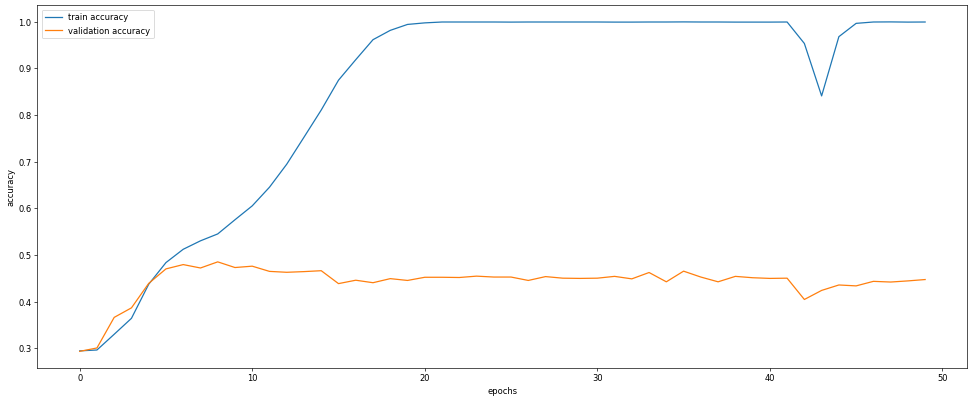

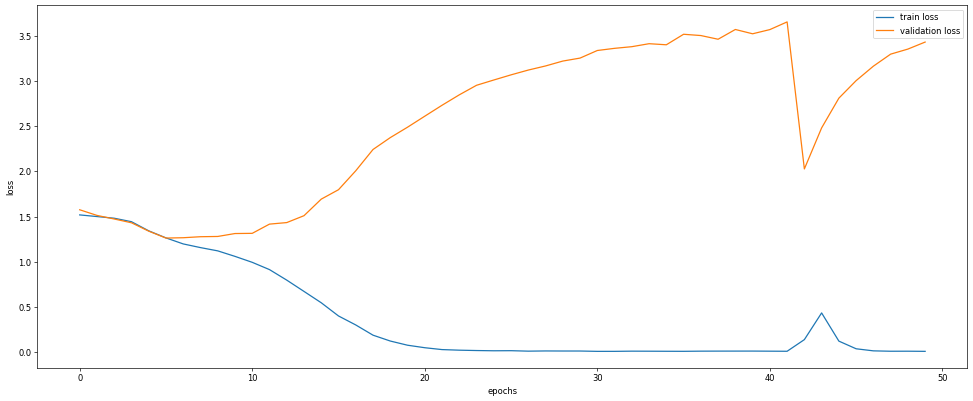

TypeError: ignored

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(derv_1,y_, test_size=0.3, random_state=42)
model, history = generate_model_1(1, 50, X_train, X_test, y_train, y_test, 0.0001)
paint_acc_loss(history)
paint_roc(model,X_test,  y_test)

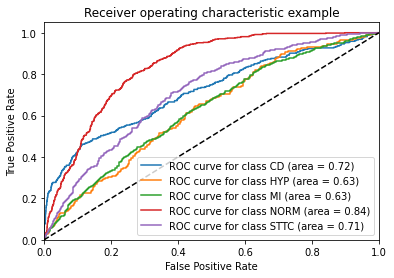

In [ ]:
paint_roc(model,X_test,  y_test)

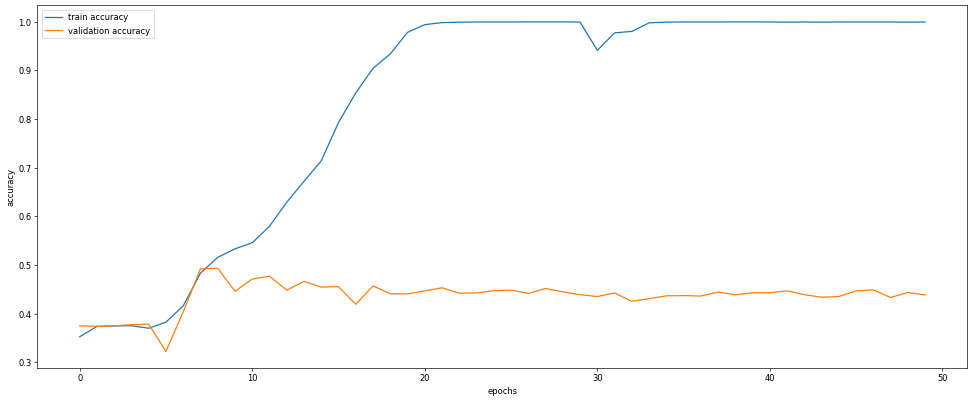

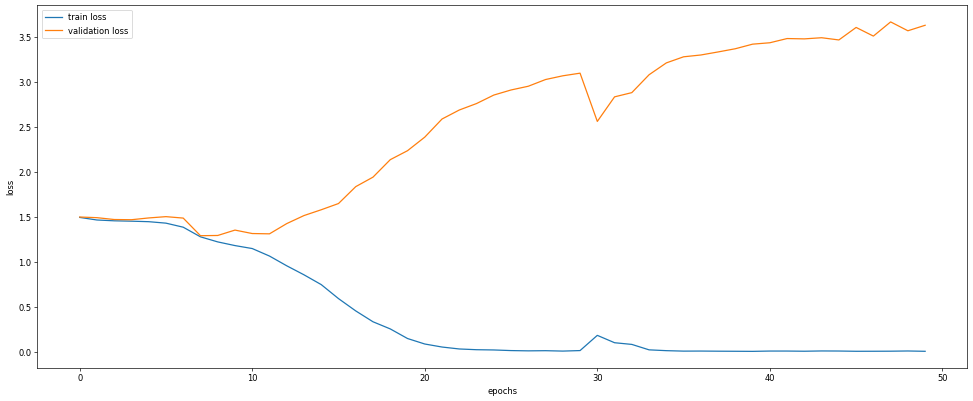

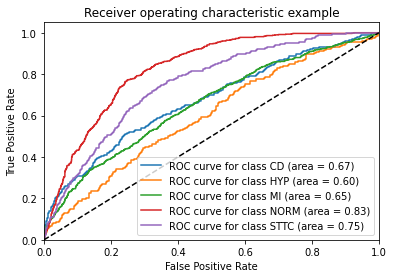

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(derv_10,y_, test_size=0.3, random_state=42)
model, history = generate_model_1(1, 50, X_train, X_test, y_train, y_test, 0.0001)
paint_acc_loss(history)
paint_roc(model,X_test,  y_test)

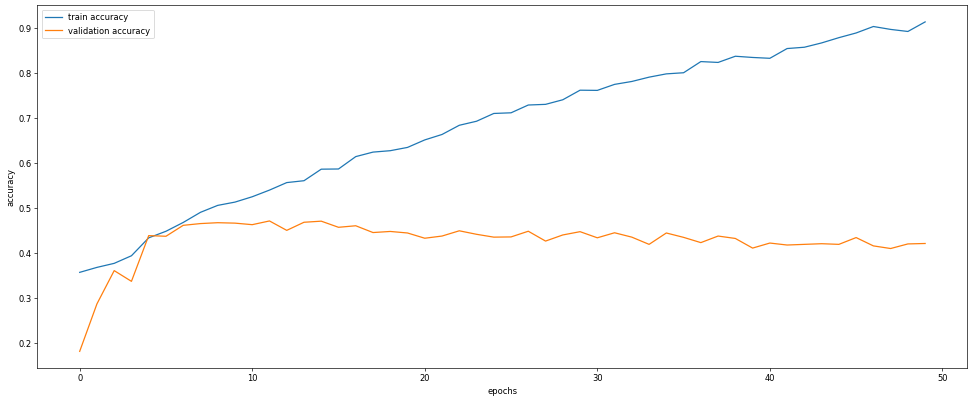

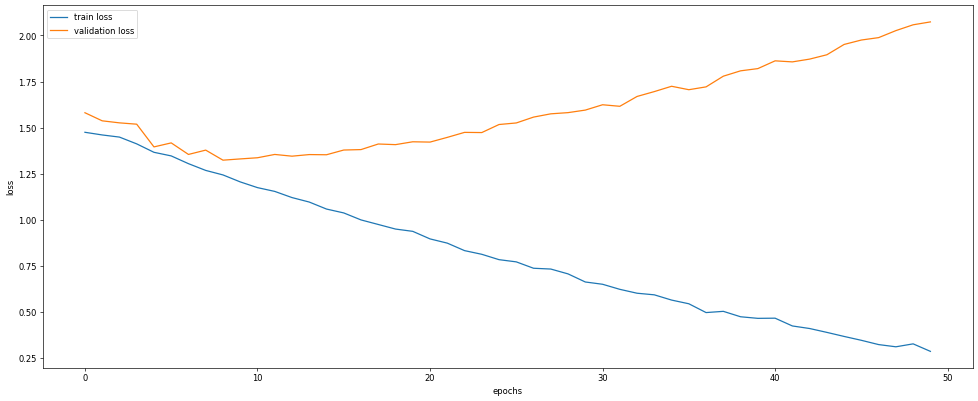

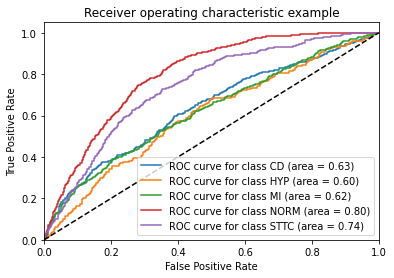

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(derv_10,y_, test_size=0.3, random_state=42)
model, history = generate_model_2(1, 50, X_train, X_test, y_train, y_test, 0.0001)
paint_acc_loss(history)
paint_roc(model,X_test,  y_test)

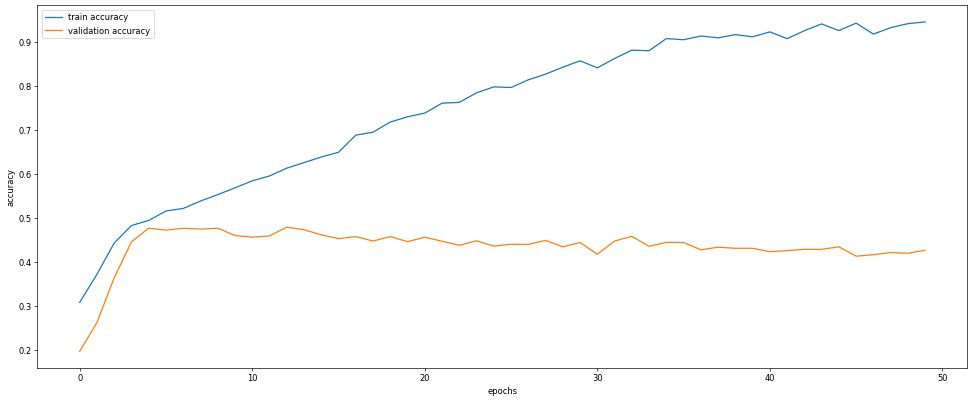

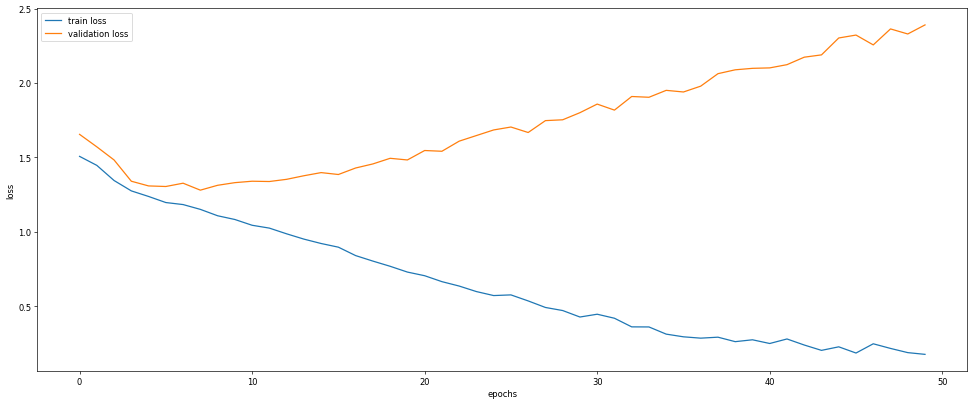

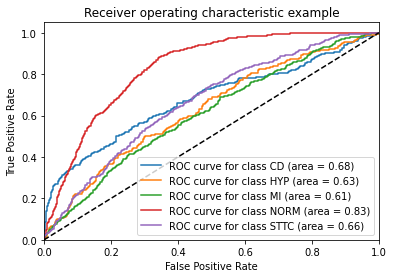

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(derv_1,y_, test_size=0.3, random_state=42)
model, history = generate_model_2(1, 50, X_train, X_test, y_train, y_test, 0.0001)
paint_acc_loss(history)
paint_roc(model,X_test,  y_test)

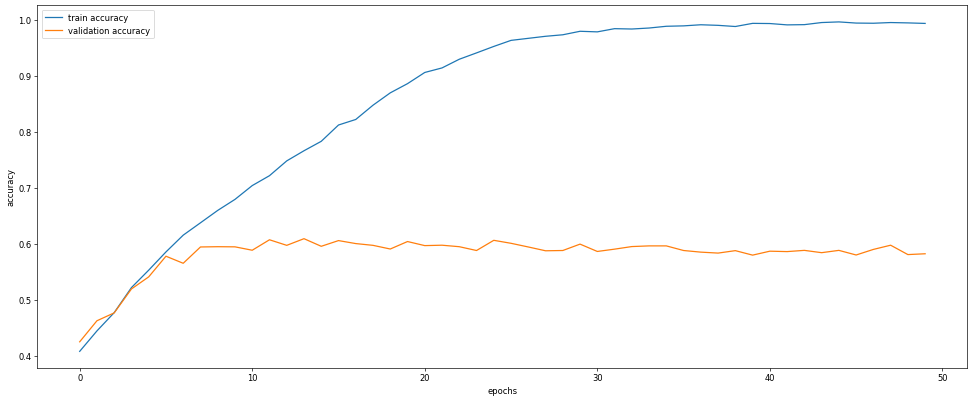

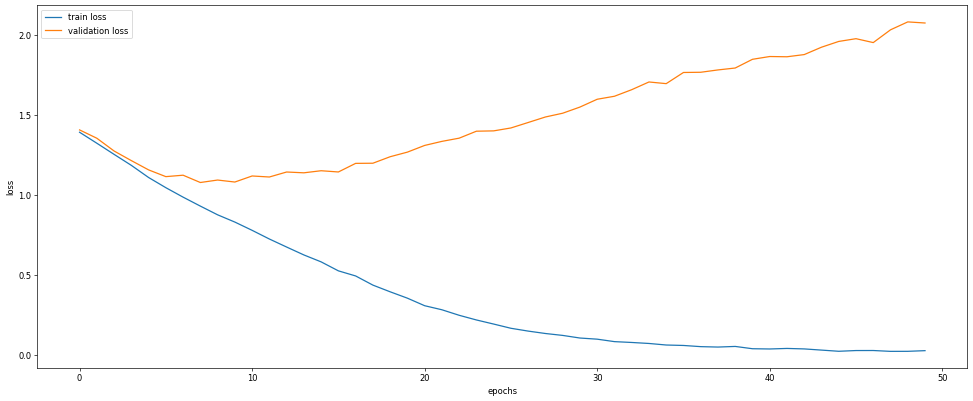

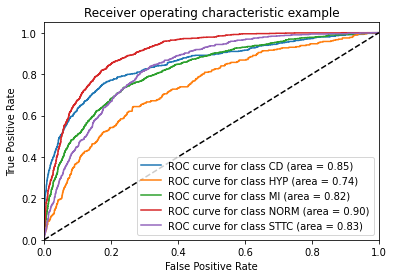

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y_, test_size=0.3, random_state=42)
model, history = generate_model_1(12, 50, X_train, X_test, y_train, y_test, 0.0001)
paint_acc_loss(history)
paint_roc(model)

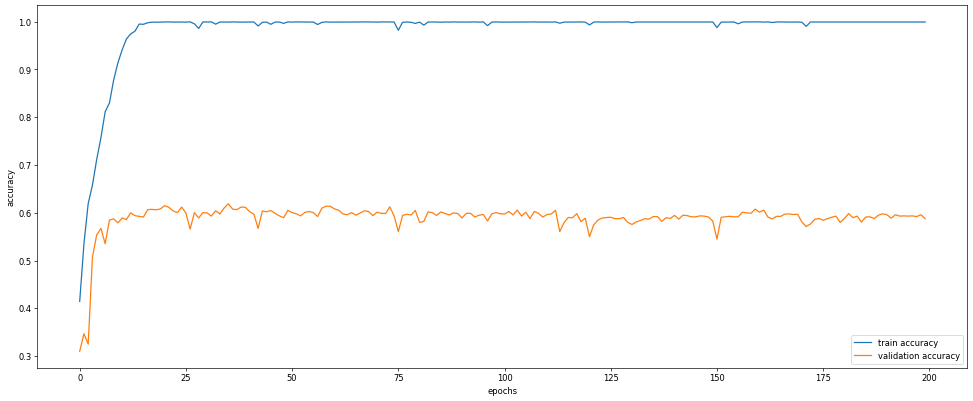

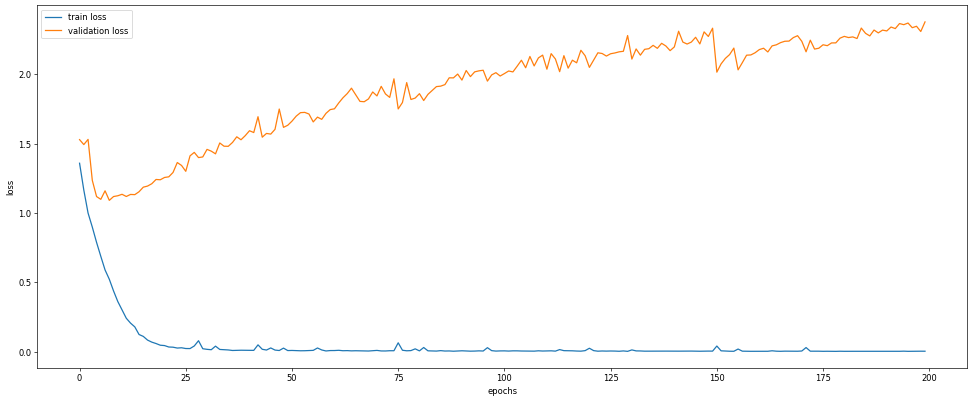

TypeError: ignored

In [ ]:
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(derv_1,y_, test_size=0.3, random_state=42)
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(derv_2,y_, test_size=0.3, random_state=42)
X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(derv_3,y_, test_size=0.3, random_state=42)
X_train_4, X_test_4, y_train_4, y_test_4 = train_test_split(derv_4,y_, test_size=0.3, random_state=42)
X_train_5, X_test_5, y_train_5, y_test_5 = train_test_split(derv_5,y_, test_size=0.3, random_state=42)
X_train_6, X_test_6, y_train_6, y_test_6 = train_test_split(derv_6,y_, test_size=0.3, random_state=42)
X_train_7, X_test_7, y_train_7, y_test_7 = train_test_split(derv_7,y_, test_size=0.3, random_state=42)
X_train_8, X_test_8, y_train_8, y_test_8 = train_test_split(derv_8,y_, test_size=0.3, random_state=42)
X_train_9, X_test_9, y_train_9, y_test_9 = train_test_split(derv_9,y_, test_size=0.3, random_state=42)
X_train_10, X_test_10, y_train_10, y_test_10 = train_test_split(derv_10,y_, test_size=0.3, random_state=42)
X_train_11, X_test_11, y_train_11, y_test_11 = train_test_split(derv_11,y_, test_size=0.3, random_state=42)
X_train_12, X_test_12, y_train_12, y_test_12 = train_test_split(derv_12,y_, test_size=0.3, random_state=42)
model, history = generate_model_4(1, 200, [X_train_1,X_train_2,X_train_3,X_train_4,X_train_5,X_train_6,X_train_7,
                                          X_train_8,X_train_9,X_train_10,X_train_11,X_train_12], 
                                  [X_test_1,X_test_2,X_test_3,X_test_4,X_test_5,X_test_6,X_test_7,X_test_8,
                                   X_test_9,X_test_10,X_test_11,X_test_12], y_train_1, y_test_1, 0.0001)
paint_acc_loss(history)
paint_roc(model)

In [ ]:
y_test_1

array([[0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.]], dtype=float32)

In [ ]:
y_test_2

array([[0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.]], dtype=float32)

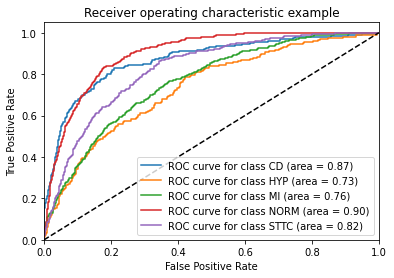

In [ ]:
paint_roc(model,[X_test_1,X_test_2,X_test_3,X_test_4,X_test_5,X_test_6,X_test_7,X_test_8,
                                   X_test_9,X_test_10,X_test_11,X_test_12],y_test_1)

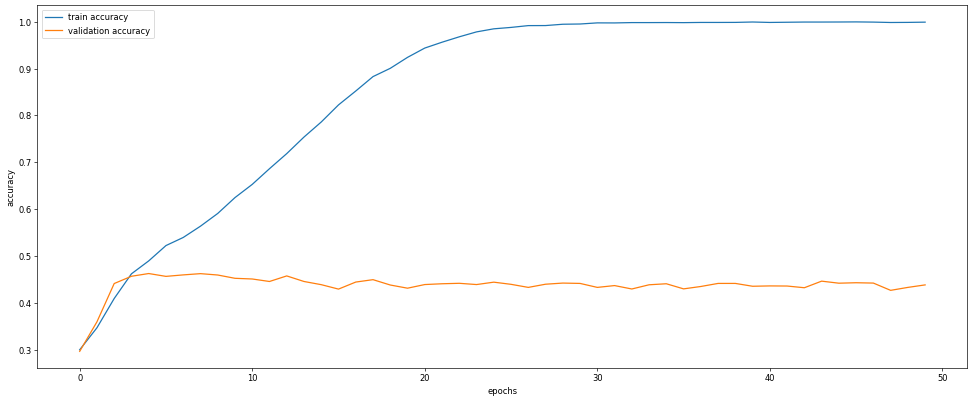

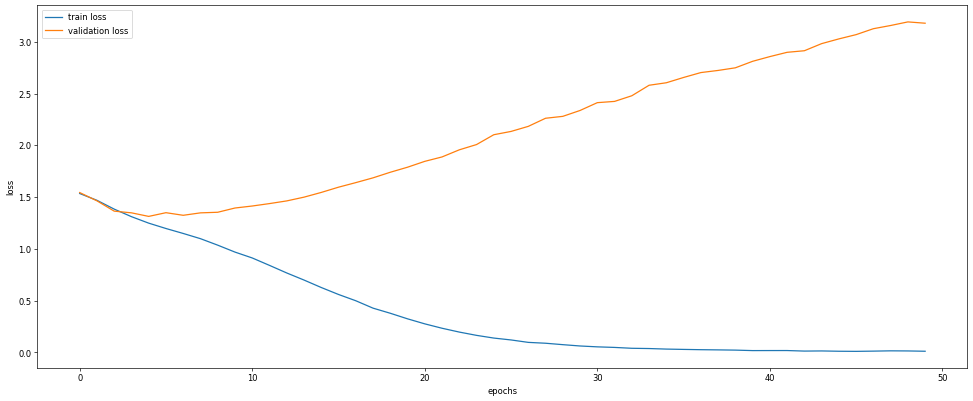

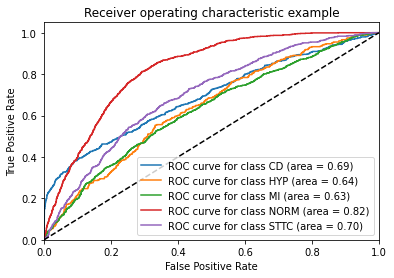

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(derv_1,y_, test_size=0.3, random_state=42)
model, history = generate_model_1(1, 50, X_train, X_test, y_train, y_test, 0.0001)
paint_acc_loss(history)
paint_roc(model)

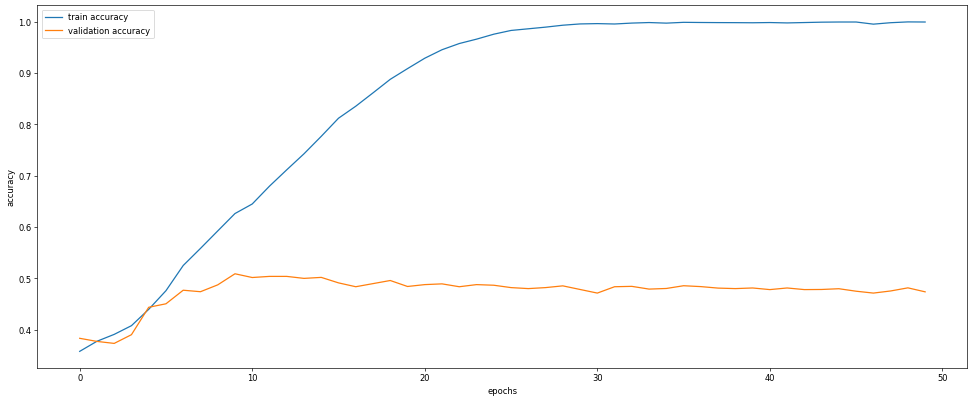

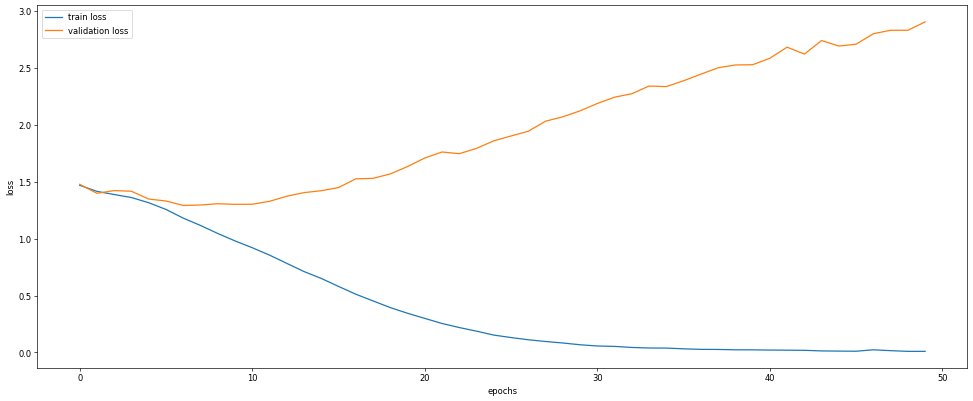

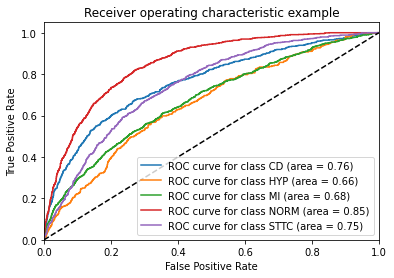

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(derv_2,y_, test_size=0.3, random_state=42)
model, history = generate_model_1(1, 50, X_train, X_test, y_train, y_test, 0.0001)
paint_acc_loss(history)
paint_roc(model)

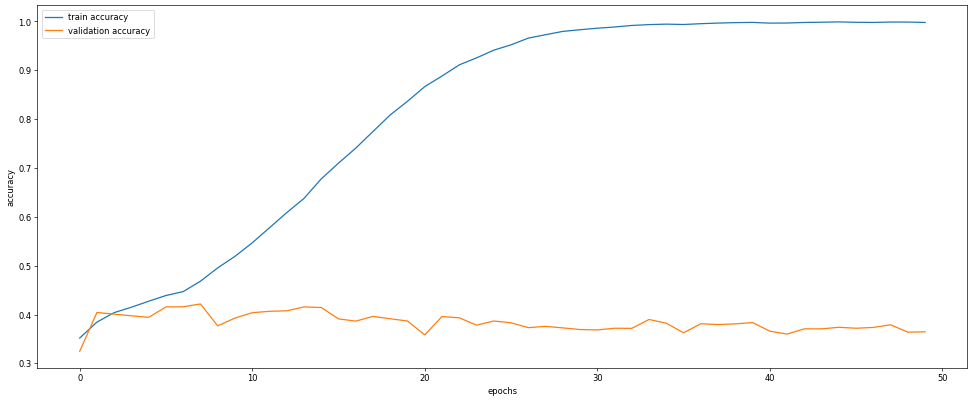

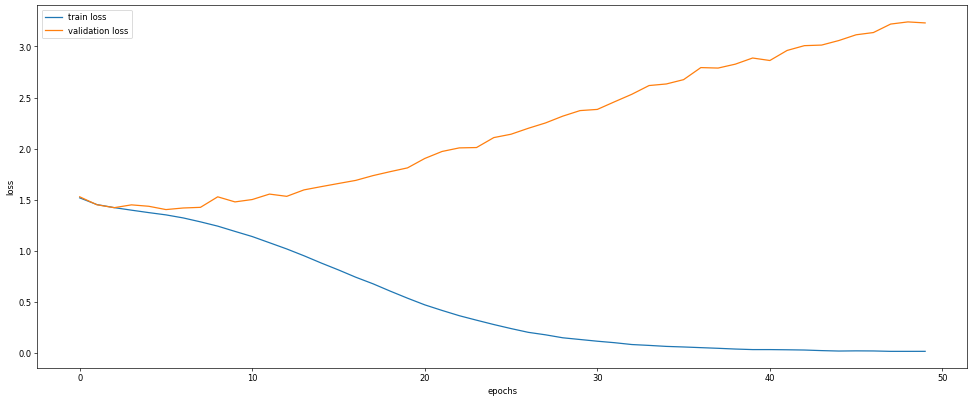

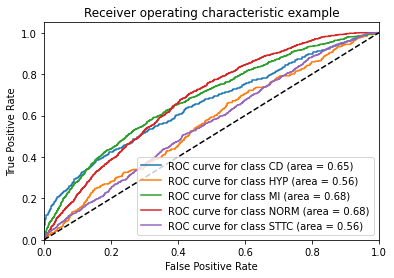

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(derv_3,y_, test_size=0.3, random_state=42)
model, history = generate_model_1(1, 50, X_train, X_test, y_train, y_test, 0.0001)
paint_acc_loss(history)
paint_roc(model)

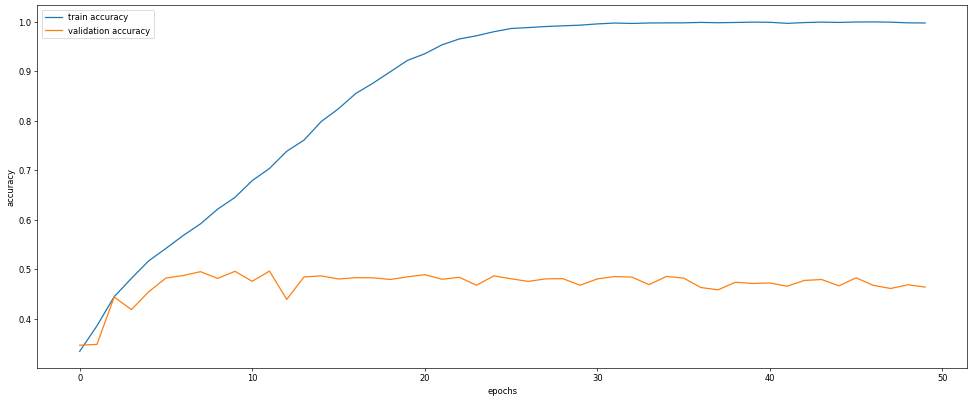

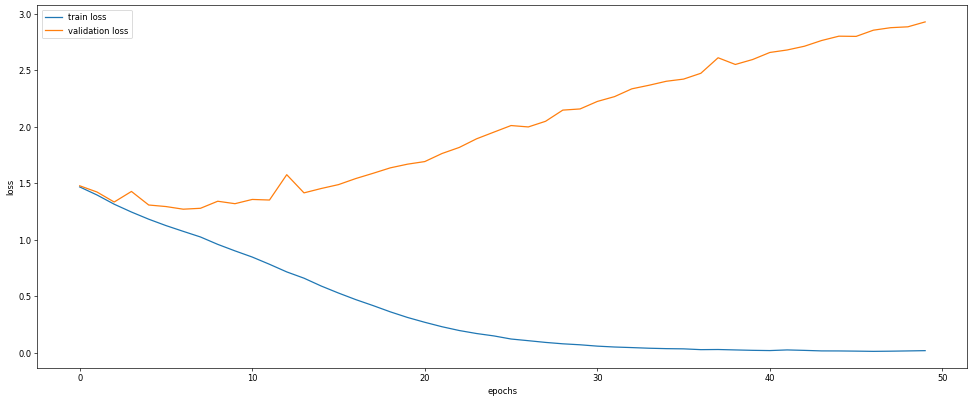

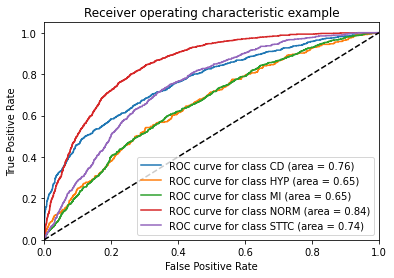

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(derv_4,y_, test_size=0.3, random_state=42)
model, history = generate_model_1(1, 50, X_train, X_test, y_train, y_test, 0.0001)
paint_acc_loss(history)
paint_roc(model)

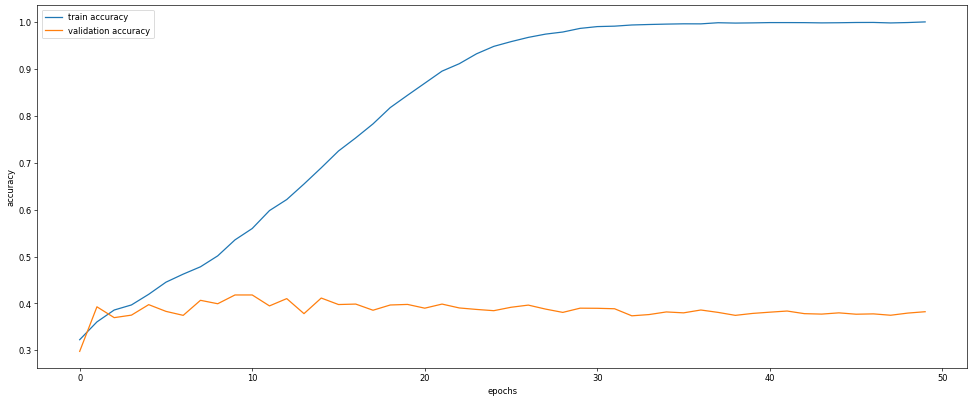

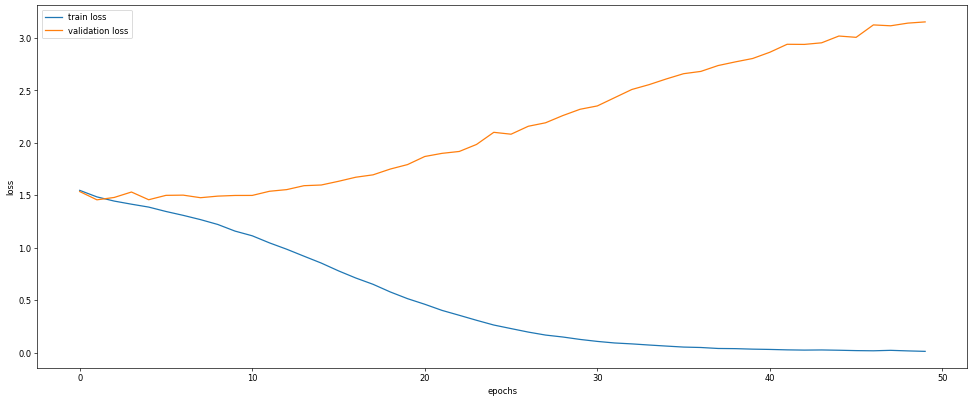

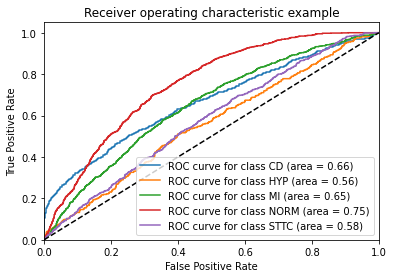

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(derv_5,y_, test_size=0.3, random_state=42)
model, history = generate_model_1(1, 50, X_train, X_test, y_train, y_test, 0.0001)
paint_acc_loss(history)
paint_roc(model)

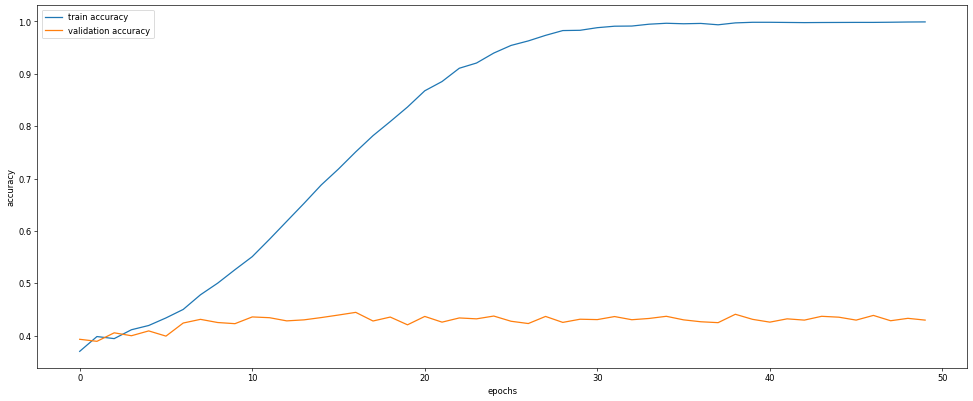

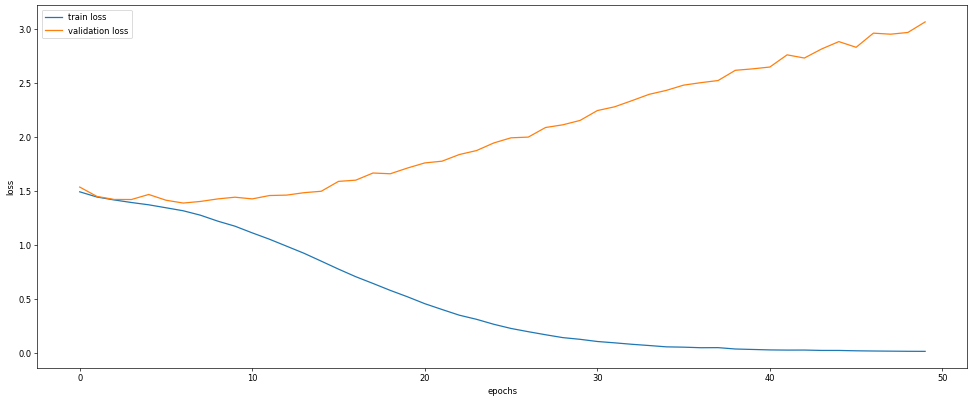

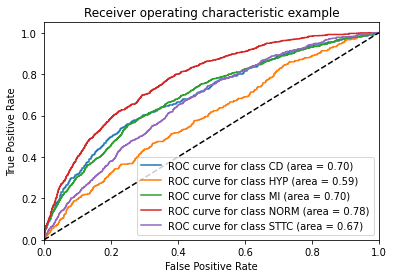

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(derv_6,y_, test_size=0.3, random_state=42)
model, history = generate_model_1(1, 50, X_train, X_test, y_train, y_test, 0.0001)
paint_acc_loss(history)
paint_roc(model)

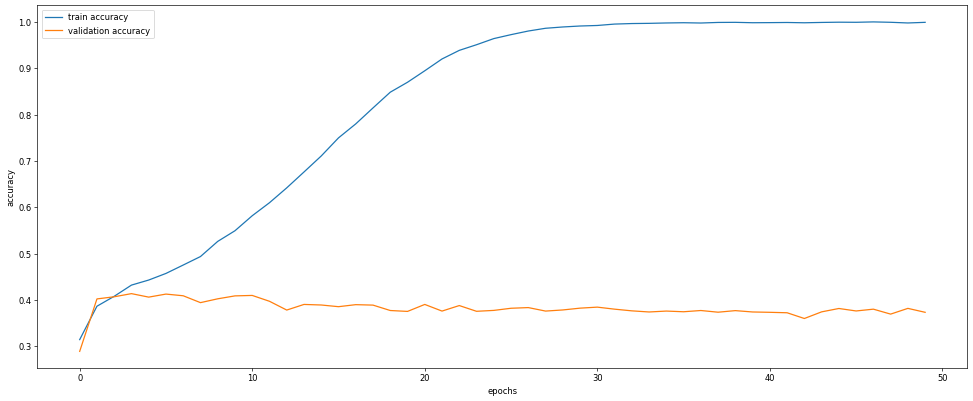

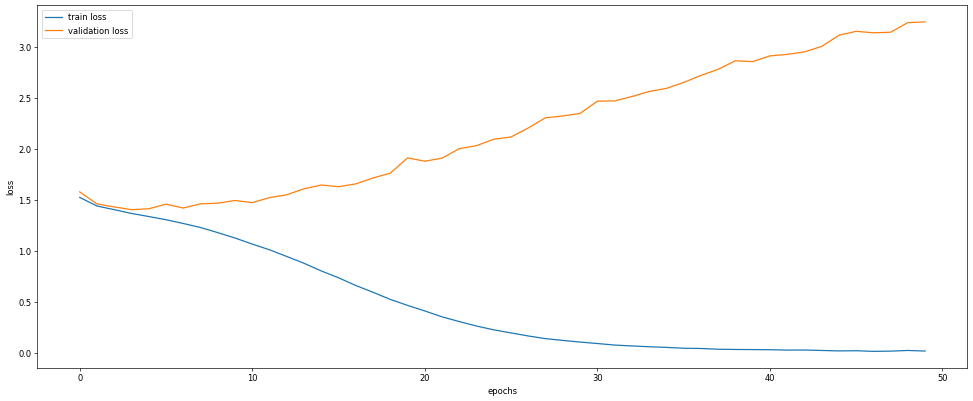

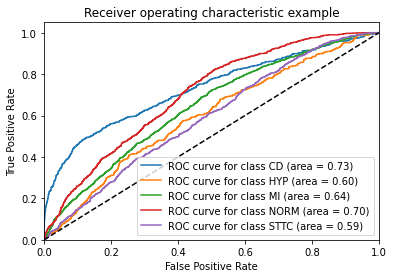

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(derv_7,y_, test_size=0.3, random_state=42)
model, history = generate_model_1(1, 50, X_train, X_test, y_train, y_test, 0.0001)
paint_acc_loss(history)
paint_roc(model)

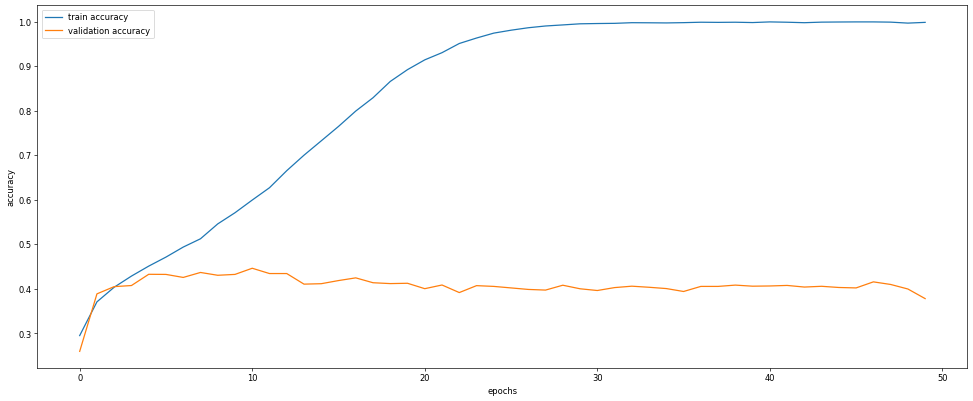

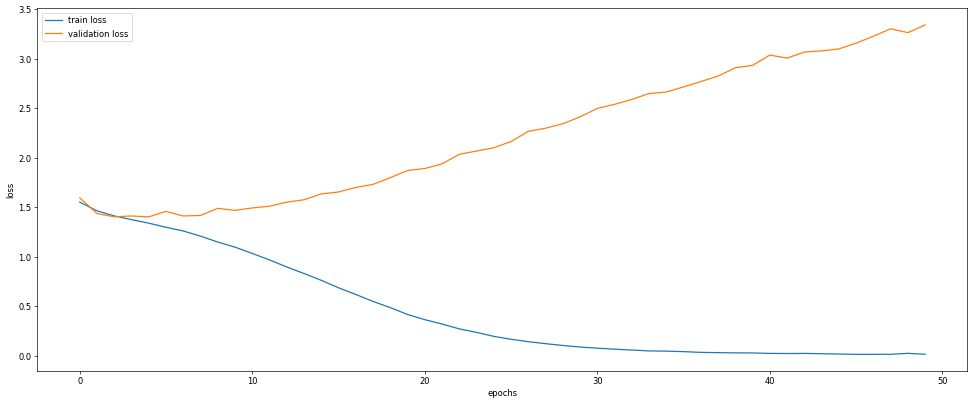

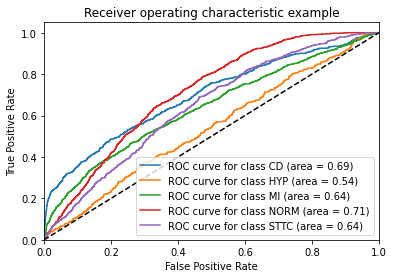

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(derv_8,y_, test_size=0.3, random_state=42)
model, history = generate_model_1(1, 50, X_train, X_test, y_train, y_test, 0.0001)
paint_acc_loss(history)
paint_roc(model)

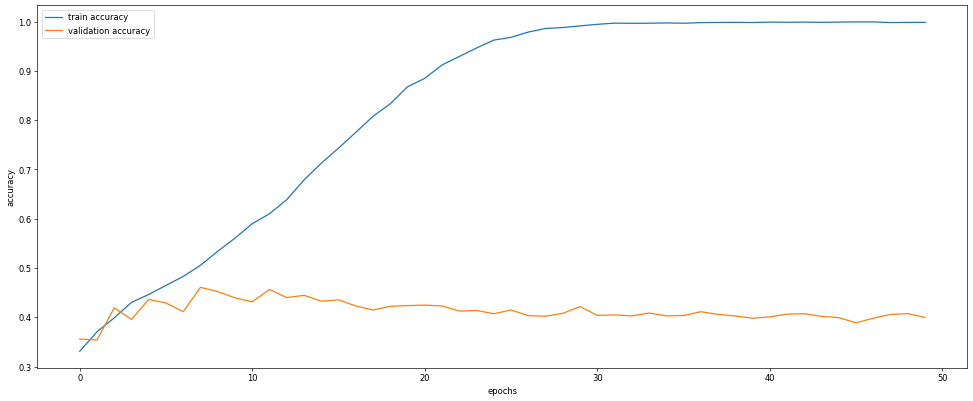

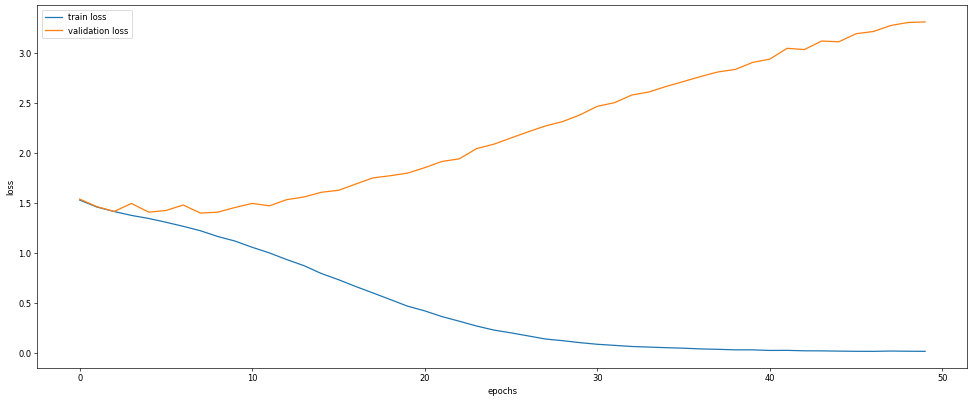

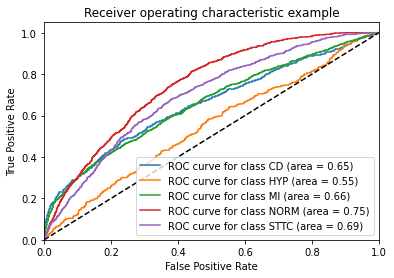

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(derv_9,y_, test_size=0.3, random_state=42)
model, history = generate_model_1(1, 50, X_train, X_test, y_train, y_test, 0.0001)
paint_acc_loss(history)
paint_roc(model)

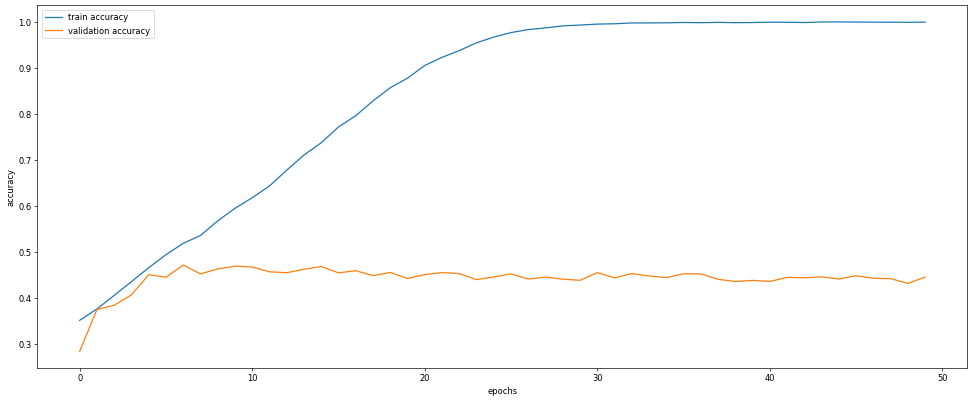

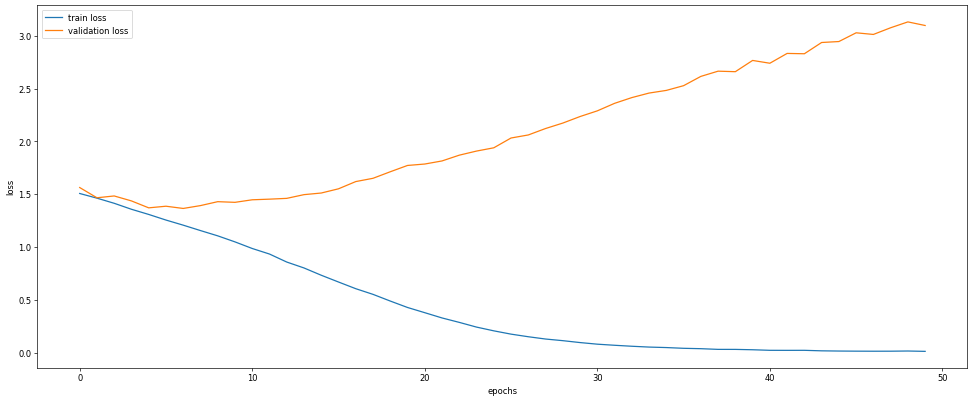

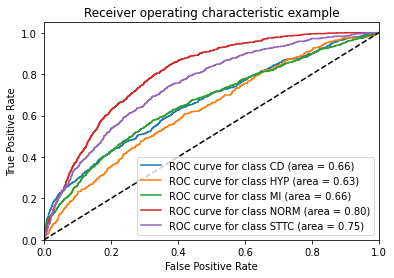

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(derv_10,y_, test_size=0.3, random_state=42)
model, history = generate_model_1(1, 50, X_train, X_test, y_train, y_test, 0.0001)
paint_acc_loss(history)
paint_roc(model)

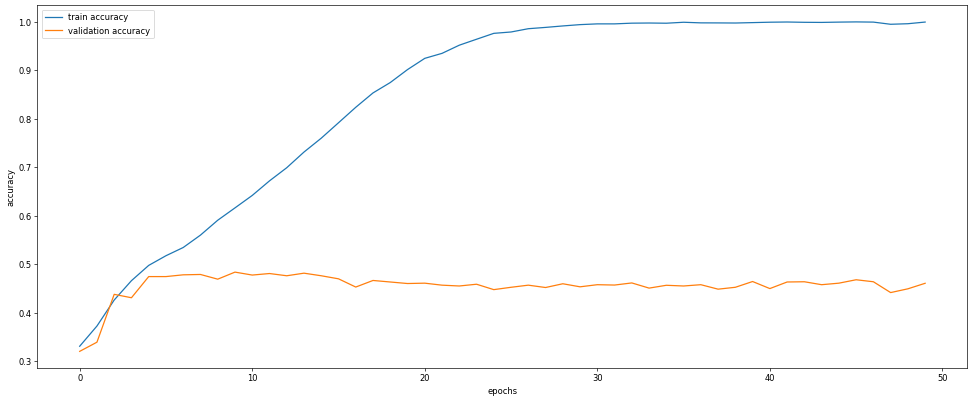

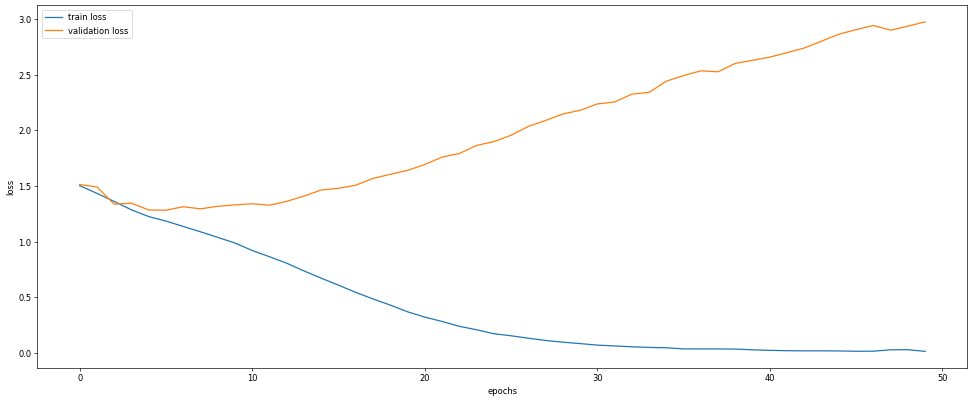

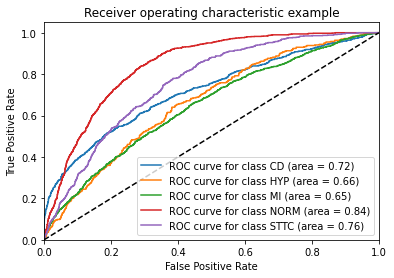

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(derv_11,y_, test_size=0.3, random_state=42)
model, history = generate_model_1(1, 50, X_train, X_test, y_train, y_test, 0.0001)
paint_acc_loss(history)
paint_roc(model)

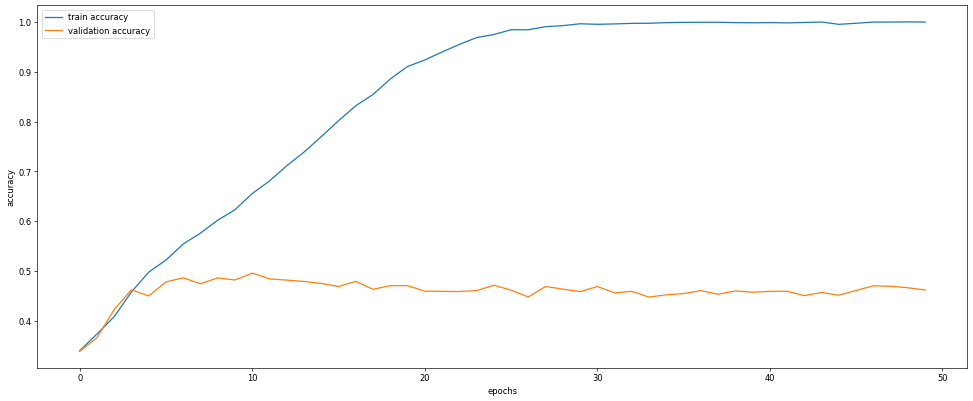

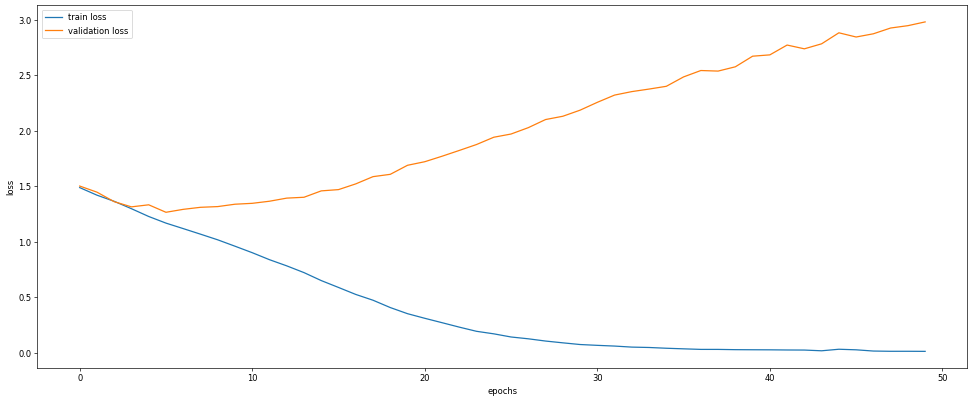

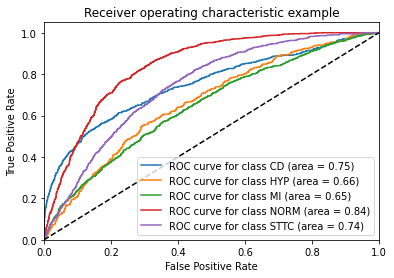

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(derv_12,y_, test_size=0.3, random_state=42)
model, history = generate_model_1(1, 50, X_train, X_test, y_train, y_test, 0.0001)
paint_acc_loss(history)
paint_roc(model)

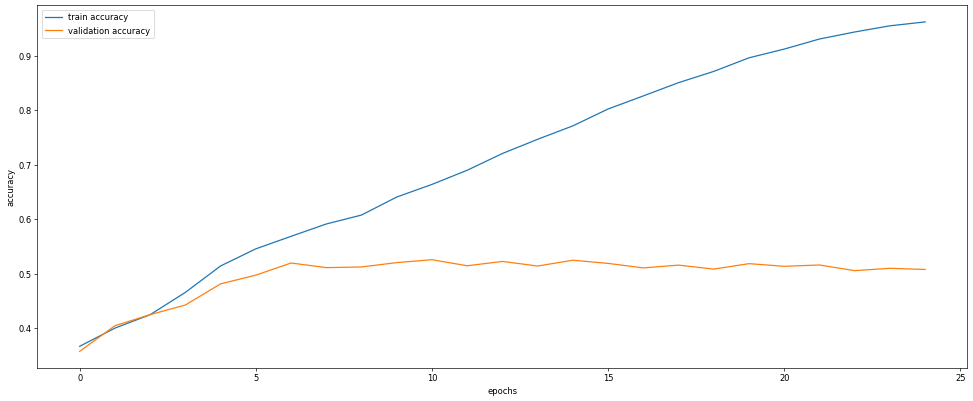

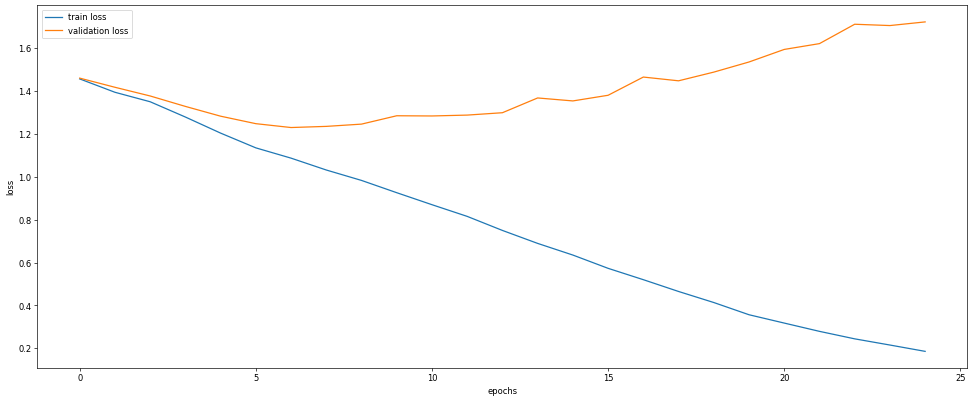

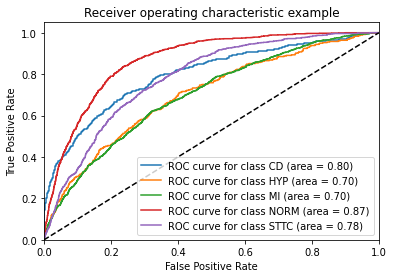

In [ ]:
test3 = np.concatenate((derv_4,derv_10,derv_11, derv_12),axis=2)
X_train, X_test, y_train, y_test = train_test_split(test3,y_, test_size=0.3, random_state=42)
model, history = generate_model_1(4, 25, X_train, X_test, y_train, y_test, 0.0001)
paint_acc_loss(history)
paint_roc(model)

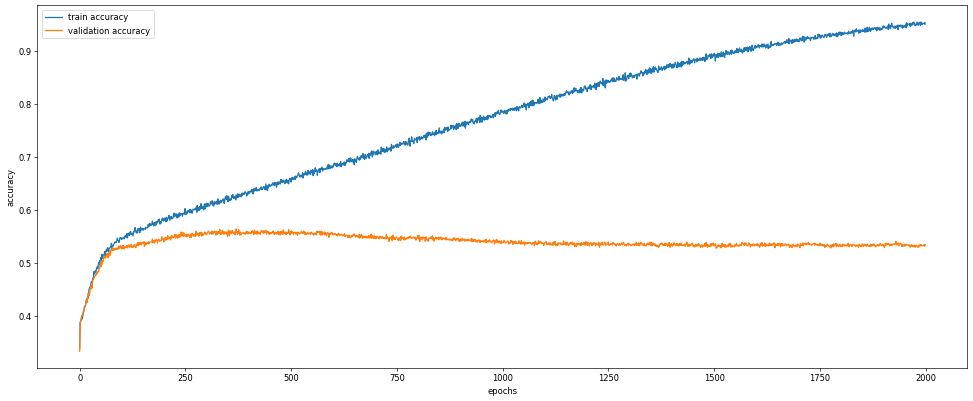

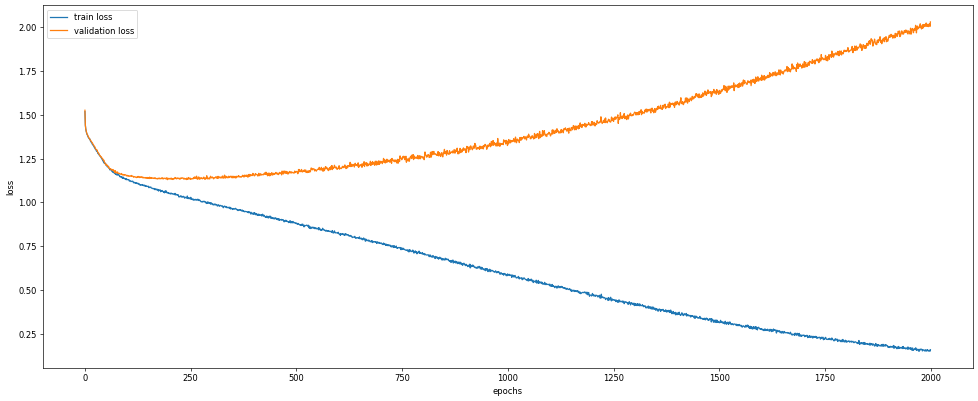

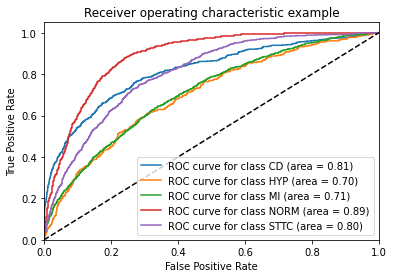

In [ ]:
test3 = np.concatenate((derv_4,derv_10,derv_11, derv_12),axis=2)
X_train, X_test, y_train, y_test = train_test_split(test3,y_, test_size=0.3, random_state=42)
model, history = generate_model_2(4, 2000, X_train, X_test, y_train, y_test, 0.000001)
paint_acc_loss(history)
paint_roc(model)

# Modelo 1

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_,y_, test_size=0.3, random_state=42)

NameError: ignored

In [ ]:
np.unique(reverse_transform(y_train), return_counts=True)

In [ ]:
np.unique(reverse_transform(y_test), return_counts=True)

In [ ]:
input = Input((input_size,12))
ecg_model = Dropout(rate=0.7)(input)
ecg_model = Conv1D(64,kernel_size=13,strides=6)(input)
ecg_model = BatchNormalization()(ecg_model)
ecg_model = Conv1D(128,kernel_size=7,strides=4)(ecg_model)
ecg_model = BatchNormalization()(ecg_model)
ecg_model = Dropout(rate=0.5)(ecg_model)
ecg_model = Conv1D(256,kernel_size=3,strides=2)(ecg_model)
ecg_model = BatchNormalization()(ecg_model)
ecg_model = Dropout(rate=0.3)(ecg_model)
ecg_model = LSTM(128, go_backwards=True, return_sequences=True)(ecg_model)
ecg_model = Flatten()(ecg_model)
ecg_model = Dense(64, activation='relu')(ecg_model)
o  = Dense(categories, activation='softmax')(ecg_model)
 
model = Model(inputs = input, outputs = o)
opt = Adam(lr=0.0001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=["accuracy"])

In [ ]:
from IPython.display import SVG, display, clear_output
from keras.utils.vis_utils import model_to_dot
display(SVG(model_to_dot(model, show_shapes=True, dpi=50).create(prog='dot', format='svg')))

In [ ]:
history6 = model.fit(X_train,y_train, epochs=100,verbose=1, validation_data=(X_test,y_test))

In [ ]:
plt.figure(figsize=(20,8), dpi= 60)
plt.plot(history6.history['accuracy'],label='train accuracy')
plt.plot(history6.history['val_accuracy'],label='validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend()
 
plt.show()
 
plt.figure(figsize=(20,8), dpi= 60)
plt.plot(history6.history['loss'],label='train loss')
plt.plot(history6.history['val_loss'],label='validation loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend()
plt.show()

In [ ]:
fpr = dict()
tpr = dict()
roc_auc = dict()
 
for i in range(categories):
  from sklearn.metrics import roc_curve, roc_auc_score, auc
  y_pred_keras = model.predict(X_test)
 
  fpr[i], tpr[i], _  = roc_curve(y_test[:, i], y_pred_keras[:, i])
  roc_auc[i] = auc(fpr[i], tpr[i])
 
plt.figure()
for i in range(categories):
  plt.plot(fpr[i], tpr[i], label='ROC curve for class %d (area = %0.2f)' % (i+1, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [ ]:
input = Input((input_size,1))
ecg_model = Dropout(rate=0.7)(input)
ecg_model = Conv1D(64,kernel_size=7,strides=4)(input)
ecg_model = BatchNormalization()(ecg_model)
ecg_model = Conv1D(128,kernel_size=5,strides=3)(ecg_model)
ecg_model = BatchNormalization()(ecg_model)
ecg_model = Dropout(rate=0.5)(ecg_model)
ecg_model = Conv1D(256,kernel_size=3,strides=2)(ecg_model)
ecg_model = BatchNormalization()(ecg_model)
ecg_model = Dropout(rate=0.3)(ecg_model)
ecg_model = LSTM(128, go_backwards=True, return_sequences=True)(ecg_model)
ecg_model = LSTM(128, return_sequences=True)(ecg_model)
ecg_model = LSTM(128, go_backwards=True, return_sequences=True)(ecg_model)
ecg_model = LSTM(128, return_sequences=True)(ecg_model)
ecg_model = Flatten()(ecg_model)
ecg_model = Dense(64, activation='relu')(ecg_model)
o  = Dense(categories, activation='softmax')(ecg_model)
 
model3 = Model(inputs = input, outputs = o)
opt = Adam(lr=0.0001)
model3.compile(optimizer=opt, loss='categorical_crossentropy', metrics=["accuracy"])
X_train, X_test, y_train, y_test = train_test_split(derv_1,y_, test_size=0.3, random_state=42)
history8 = model3.fit(X_train,y_train, epochs=100,verbose=1, validation_data=(X_test,y_test))



In [ ]:
plt.figure(figsize=(20,8), dpi= 60)
plt.plot(history8.history['accuracy'],label='train accuracy')
plt.plot(history8.history['val_accuracy'],label='validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend()
 
plt.show()
 
plt.figure(figsize=(20,8), dpi= 60)
plt.plot(history8.history['loss'],label='train loss')
plt.plot(history8.history['val_loss'],label='validation loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend()
plt.show()

In [ ]:
fpr = dict()
tpr = dict()
roc_auc = dict()
 
for i in range(categories):
  from sklearn.metrics import roc_curve, roc_auc_score, auc
  y_pred_keras = model3.predict(X_test)
 
  fpr[i], tpr[i], _  = roc_curve(y_test[:, i], y_pred_keras[:, i])
  roc_auc[i] = auc(fpr[i], tpr[i])
 
plt.figure()
for i in range(categories):
  plt.plot(fpr[i], tpr[i], label='ROC curve for class %d (area = %0.2f)' % (i+1, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [ ]:
input = Input((input_size,1))
ecg_model = Dropout(rate=0.7)(input)
ecg_model = Conv1D(64,kernel_size=13,strides=6)(input)
ecg_model = BatchNormalization()(ecg_model)
ecg_model = Conv1D(128,kernel_size=7,strides=4)(ecg_model)
ecg_model = BatchNormalization()(ecg_model)
ecg_model = Dropout(rate=0.5)(ecg_model)
ecg_model = Conv1D(256,kernel_size=3,strides=2)(ecg_model)
ecg_model = BatchNormalization()(ecg_model)
ecg_model = Dropout(rate=0.3)(ecg_model)
ecg_model = LSTM(128, go_backwards=True, return_sequences=True)(ecg_model)
ecg_model = Flatten()(ecg_model)
ecg_model = Dense(64, activation='relu')(ecg_model)
o  = Dense(categories, activation='softmax')(ecg_model)
 
model4 = Model(inputs = input, outputs = o)
opt = Adam(lr=0.0001)
model4.compile(optimizer=opt, loss='categorical_crossentropy', metrics=["accuracy"])
X_train, X_test, y_train, y_test = train_test_split(derv_2,y_, test_size=0.3, random_state=42)
history9 = model4.fit(X_train,y_train, epochs=100,verbose=1, validation_data=(X_test,y_test))

In [ ]:
fpr = dict()
tpr = dict()
roc_auc = dict()
 
for i in range(categories):
  from sklearn.metrics import roc_curve, roc_auc_score, auc
  y_pred_keras = model4.predict(X_test)
 
  fpr[i], tpr[i], _  = roc_curve(y_test[:, i], y_pred_keras[:, i])
  roc_auc[i] = auc(fpr[i], tpr[i])
 
plt.figure()
for i in range(categories):
  plt.plot(fpr[i], tpr[i], label='ROC curve for class %d (area = %0.2f)' % (i+1, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [ ]:
input = Input((input_size,1))
ecg_model = Dropout(rate=0.7)(input)
ecg_model = Conv1D(64,kernel_size=13,strides=6)(input)
ecg_model = BatchNormalization()(ecg_model)
ecg_model = Conv1D(128,kernel_size=7,strides=4)(ecg_model)
ecg_model = BatchNormalization()(ecg_model)
ecg_model = Dropout(rate=0.5)(ecg_model)
ecg_model = Conv1D(256,kernel_size=3,strides=2)(ecg_model)
ecg_model = BatchNormalization()(ecg_model)
ecg_model = Dropout(rate=0.3)(ecg_model)
ecg_model = LSTM(128, go_backwards=True, return_sequences=True)(ecg_model)
ecg_model = Flatten()(ecg_model)
ecg_model = Dense(64, activation='relu')(ecg_model)
o  = Dense(categories, activation='softmax')(ecg_model)
 
model5 = Model(inputs = input, outputs = o)
opt = Adam(lr=0.0001)
model5.compile(optimizer=opt, loss='categorical_crossentropy', metrics=["accuracy"])
X_train, X_test, y_train, y_test = train_test_split(derv_3,y_, test_size=0.3, random_state=42)
history10 = model5.fit(X_train,y_train, epochs=100,verbose=1, validation_data=(X_test,y_test))

In [ ]:
fpr = dict()
tpr = dict()
roc_auc = dict()
 
for i in range(categories):
  from sklearn.metrics import roc_curve, roc_auc_score, auc
  y_pred_keras = model5.predict(X_test)
 
  fpr[i], tpr[i], _  = roc_curve(y_test[:, i], y_pred_keras[:, i])
  roc_auc[i] = auc(fpr[i], tpr[i])
 
plt.figure()
for i in range(categories):
  plt.plot(fpr[i], tpr[i], label='ROC curve for class %d (area = %0.2f)' % (i+1, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [ ]:
input = Input((input_size,1))
ecg_model = Conv1D(64,kernel_size=20, strides=11)(input)
ecg_model = MaxPooling1D(pool_size=2)(ecg_model)
ecg_model = Conv1D(128,kernel_size=12, strides=7)(ecg_model)
ecg_model = MaxPooling1D(pool_size=2)(ecg_model)
ecg_model = BatchNormalization()(ecg_model)
ecg_model = LSTM(64, return_sequences=True)(ecg_model)
ecg_model = Flatten()(ecg_model)
ecg_model = Dense(32, activation='relu')(ecg_model)
o  = Dense(categories, activation='softmax')(ecg_model)
 
model6 = Model(inputs = input, outputs = o)
opt = Adam(lr=0.00001)
model6.compile(optimizer=opt, loss='categorical_crossentropy', metrics=["accuracy"])
X_train, X_test, y_train, y_test = train_test_split(derv_3,y_, test_size=0.3, random_state=1)
history10 = model6.fit(X_train,y_train, epochs=100,verbose=1, validation_data=(X_test,y_test))

In [ ]:
plt.figure(figsize=(20,8), dpi= 60)
plt.plot(history10.history['accuracy'],label='train accuracy')
plt.plot(history10.history['val_accuracy'],label='validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend()
 
plt.show()
 
plt.figure(figsize=(20,8), dpi= 60)
plt.plot(history10.history['loss'],label='train loss')
plt.plot(history10.history['val_loss'],label='validation loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend()
plt.show()

In [ ]:
fpr = dict()
tpr = dict()
roc_auc = dict()
 
for i in range(categories):
  from sklearn.metrics import roc_curve, roc_auc_score, auc
  y_pred_keras = model6.predict(X_test)
 
  fpr[i], tpr[i], _  = roc_curve(y_test[:, i], y_pred_keras[:, i])
  roc_auc[i] = auc(fpr[i], tpr[i])
 
plt.figure()
for i in range(categories):
  plt.plot(fpr[i], tpr[i], label='ROC curve for class %d (area = %0.2f)' % (i+1, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [ ]:
im_shape=(input_size,1)
inputs_cnn=Input(shape=(im_shape), name='inputs_cnn')
conv1_1=Conv1D(64, (6), activation='relu', input_shape=im_shape)(inputs_cnn)
conv1_1=BatchNormalization()(conv1_1)
pool1=MaxPooling1D(pool_size=(3), strides=(2), padding="same")(conv1_1)
pool1 = Dropout(rate=0.3)(pool1)
conv2_1=Conv1D(64, (3), activation='relu', input_shape=im_shape)(pool1)
conv2_1=BatchNormalization()(conv2_1)
pool2=MaxPooling1D(pool_size=(2), strides=(2), padding="same")(conv2_1)
pool2 = Dropout(rate=0.3)(pool2)
conv3_1=Conv1D(64, (3), activation='relu', input_shape=im_shape)(pool2)
conv3_1=BatchNormalization()(conv3_1)
pool3=MaxPooling1D(pool_size=(2), strides=(2), padding="same")(conv3_1)
flatten=Flatten()(pool3)
dense_end1 = Dense(64, activation='relu')(flatten)
dense_end2 = Dense(32, activation='relu')(dense_end1)
main_output = Dense(categories, activation='softmax', name='main_output')(dense_end2)

model = Model(inputs= inputs_cnn, outputs=main_output)
opt = Adam(lr=0.001)
model.compile(optimizer=opt, loss='categorical_crossentropy',metrics = ['accuracy'])


#callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8),
#          tf.keras.callbacks.ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

history=model.fit(X_train, y_train,epochs=100, batch_size=32,validation_data=(X_test,y_test))
#model.load_weights('best_model.h5')callbacks=callbacks,

In [ ]:
input = Input((input_size,1))
ecg_model = Dropout(rate=0.3)(input)
ecg_model = Conv1D(64,kernel_size=13,strides=6)(input)
ecg_model = Conv1D(128,kernel_size=7,strides=4)(ecg_model)
ecg_model = BatchNormalization()(ecg_model)
ecg_model = Dropout(rate=0.3)(ecg_model)
ecg_model = Conv1D(256,kernel_size=3,strides=2)(ecg_model)
ecg_model = BatchNormalization()(ecg_model)
ecg_model = Dropout(rate=0.3)(ecg_model)
ecg_model = LSTM(128, go_backwards=True, return_sequences=True)(ecg_model)
ecg_model = Flatten()(ecg_model)
ecg_model = Dense(64, activation='relu')(ecg_model)
o  = Dense(categories, activation='softmax')(ecg_model)
 
model7 = Model(inputs = input, outputs = o)
opt = Adam(lr=0.0001)
model7.compile(optimizer=opt, loss='categorical_crossentropy', metrics=["accuracy"])
X_train, X_test, y_train, y_test = train_test_split(derv_5,y_, test_size=0.3, random_state=42)
history11 = model7.fit(X_train,y_train, epochs=100,verbose=1, validation_data=(X_test,y_test))

In [ ]:
fpr = dict()
tpr = dict()
roc_auc = dict()
 
for i in range(categories):
  from sklearn.metrics import roc_curve, roc_auc_score, auc
  y_pred_keras = model7.predict(X_test)
 
  fpr[i], tpr[i], _  = roc_curve(y_test[:, i], y_pred_keras[:, i])
  roc_auc[i] = auc(fpr[i], tpr[i])
 
plt.figure()
for i in range(categories):
  plt.plot(fpr[i], tpr[i], label='ROC curve for class %d (area = %0.2f)' % (i+1, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [ ]:
input = Input((input_size,1))
ecg_model = Dropout(rate=0.7)(input)
ecg_model = Conv1D(64,kernel_size=13,strides=6)(input)
ecg_model = BatchNormalization()(ecg_model)
ecg_model = Conv1D(128,kernel_size=7,strides=4)(ecg_model)
ecg_model = BatchNormalization()(ecg_model)
ecg_model = Dropout(rate=0.5)(ecg_model)
ecg_model = Conv1D(256,kernel_size=3,strides=2)(ecg_model)
ecg_model = BatchNormalization()(ecg_model)
ecg_model = Dropout(rate=0.3)(ecg_model)
ecg_model = LSTM(128, go_backwards=True, return_sequences=True)(ecg_model)
ecg_model = Flatten()(ecg_model)
ecg_model = Dense(64, activation='relu')(ecg_model)
o  = Dense(categories, activation='softmax')(ecg_model)
 
model8 = Model(inputs = input, outputs = o)
opt = Adam(lr=0.0001)
model8.compile(optimizer=opt, loss='categorical_crossentropy', metrics=["accuracy"])
X_train, X_test, y_train, y_test = train_test_split(derv_6,y_, test_size=0.3, random_state=42)
history12 = model8.fit(X_train,y_train, epochs=100,verbose=1, validation_data=(X_test,y_test))

In [ ]:
fpr = dict()
tpr = dict()
roc_auc = dict()
 
for i in range(categories):
  from sklearn.metrics import roc_curve, roc_auc_score, auc
  y_pred_keras = model8.predict(X_test)
 
  fpr[i], tpr[i], _  = roc_curve(y_test[:, i], y_pred_keras[:, i])
  roc_auc[i] = auc(fpr[i], tpr[i])
 
plt.figure()
for i in range(categories):
  plt.plot(fpr[i], tpr[i], label='ROC curve for class %d (area = %0.2f)' % (i+1, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [ ]:
input = Input((input_size,1))
ecg_model = Dropout(rate=0.7)(input)
ecg_model = Conv1D(64,kernel_size=13,strides=6)(input)
ecg_model = BatchNormalization()(ecg_model)
ecg_model = Conv1D(128,kernel_size=7,strides=4)(ecg_model)
ecg_model = BatchNormalization()(ecg_model)
ecg_model = Dropout(rate=0.5)(ecg_model)
ecg_model = Conv1D(256,kernel_size=3,strides=2)(ecg_model)
ecg_model = BatchNormalization()(ecg_model)
ecg_model = Dropout(rate=0.3)(ecg_model)
ecg_model = LSTM(128, go_backwards=True, return_sequences=True)(ecg_model)
ecg_model = Flatten()(ecg_model)
ecg_model = Dense(64, activation='relu')(ecg_model)
o  = Dense(categories, activation='softmax')(ecg_model)
 
model9 = Model(inputs = input, outputs = o)
opt = Adam(lr=0.0001)
model9.compile(optimizer=opt, loss='categorical_crossentropy', metrics=["accuracy"])
X_train, X_test, y_train, y_test = train_test_split(derv_7,y_, test_size=0.3, random_state=42)
history13 = model9.fit(X_train,y_train, epochs=100,verbose=1, validation_data=(X_test,y_test))

In [ ]:
fpr = dict()
tpr = dict()
roc_auc = dict()
 
for i in range(categories):
  from sklearn.metrics import roc_curve, roc_auc_score, auc
  y_pred_keras = model9.predict(X_test)
 
  fpr[i], tpr[i], _  = roc_curve(y_test[:, i], y_pred_keras[:, i])
  roc_auc[i] = auc(fpr[i], tpr[i])
 
plt.figure()
for i in range(categories):
  plt.plot(fpr[i], tpr[i], label='ROC curve for class %d (area = %0.2f)' % (i+1, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [ ]:
input = Input((input_size,1))
ecg_model = Dropout(rate=0.7)(input)
ecg_model = Conv1D(64,kernel_size=13,strides=6)(input)
ecg_model = BatchNormalization()(ecg_model)
ecg_model = Conv1D(128,kernel_size=7,strides=4)(ecg_model)
ecg_model = BatchNormalization()(ecg_model)
ecg_model = Dropout(rate=0.5)(ecg_model)
ecg_model = Conv1D(256,kernel_size=3,strides=2)(ecg_model)
ecg_model = BatchNormalization()(ecg_model)
ecg_model = Dropout(rate=0.3)(ecg_model)
ecg_model = LSTM(128, go_backwards=True, return_sequences=True)(ecg_model)
ecg_model = Flatten()(ecg_model)
ecg_model = Dense(64, activation='relu')(ecg_model)
o  = Dense(categories, activation='softmax')(ecg_model)
 
model10 = Model(inputs = input, outputs = o)
opt = Adam(lr=0.0001)
model10.compile(optimizer=opt, loss='categorical_crossentropy', metrics=["accuracy"])
X_train, X_test, y_train, y_test = train_test_split(derv_8,y_, test_size=0.3, random_state=42)
history13 = model10.fit(X_train,y_train, epochs=100,verbose=1, validation_data=(X_test,y_test))

In [ ]:
fpr = dict()
tpr = dict()
roc_auc = dict()
 
for i in range(categories):
  from sklearn.metrics import roc_curve, roc_auc_score, auc
  y_pred_keras = model10.predict(X_test)
 
  fpr[i], tpr[i], _  = roc_curve(y_test[:, i], y_pred_keras[:, i])
  roc_auc[i] = auc(fpr[i], tpr[i])
 
plt.figure()
for i in range(categories):
  plt.plot(fpr[i], tpr[i], label='ROC curve for class %d (area = %0.2f)' % (i+1, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [ ]:
input = Input((input_size,1))
ecg_model = Dropout(rate=0.7)(input)
ecg_model = Conv1D(64,kernel_size=13,strides=6)(input)
ecg_model = BatchNormalization()(ecg_model)
ecg_model = Conv1D(128,kernel_size=7,strides=4)(ecg_model)
ecg_model = BatchNormalization()(ecg_model)
ecg_model = Dropout(rate=0.5)(ecg_model)
ecg_model = Conv1D(256,kernel_size=3,strides=2)(ecg_model)
ecg_model = BatchNormalization()(ecg_model)
ecg_model = Dropout(rate=0.3)(ecg_model)
ecg_model = LSTM(128, go_backwards=True, return_sequences=True)(ecg_model)
ecg_model = Flatten()(ecg_model)
ecg_model = Dense(64, activation='relu')(ecg_model)
o  = Dense(categories, activation='softmax')(ecg_model)
 
model11 = Model(inputs = input, outputs = o)
opt = Adam(lr=0.0001)
model11.compile(optimizer=opt, loss='categorical_crossentropy', metrics=["accuracy"])
X_train, X_test, y_train, y_test = train_test_split(derv_9,y_, test_size=0.3, random_state=42)
history13 = model11.fit(X_train,y_train, epochs=100,verbose=1, validation_data=(X_test,y_test))

In [ ]:
fpr = dict()
tpr = dict()
roc_auc = dict()
 
for i in range(categories):
  from sklearn.metrics import roc_curve, roc_auc_score, auc
  y_pred_keras = model11.predict(X_test)
 
  fpr[i], tpr[i], _  = roc_curve(y_test[:, i], y_pred_keras[:, i])
  roc_auc[i] = auc(fpr[i], tpr[i])
 
plt.figure()
for i in range(categories):
  plt.plot(fpr[i], tpr[i], label='ROC curve for class %d (area = %0.2f)' % (i+1, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [ ]:
input = Input((input_size,1))
ecg_model = Dropout(rate=0.7)(input)
ecg_model = Conv1D(64,kernel_size=13,strides=6)(input)
ecg_model = BatchNormalization()(ecg_model)
ecg_model = Conv1D(128,kernel_size=7,strides=4)(ecg_model)
ecg_model = BatchNormalization()(ecg_model)
ecg_model = Dropout(rate=0.5)(ecg_model)
ecg_model = Conv1D(256,kernel_size=3,strides=2)(ecg_model)
ecg_model = BatchNormalization()(ecg_model)
ecg_model = Dropout(rate=0.3)(ecg_model)
ecg_model = LSTM(128, go_backwards=True, return_sequences=True)(ecg_model)
ecg_model = Flatten()(ecg_model)
ecg_model = Dense(64, activation='relu')(ecg_model)
o  = Dense(categories, activation='softmax')(ecg_model)
 
model12 = Model(inputs = input, outputs = o)
opt = Adam(lr=0.0001)
model12.compile(optimizer=opt, loss='categorical_crossentropy', metrics=["accuracy"])
X_train, X_test, y_train, y_test = train_test_split(derv_10,y_, test_size=0.3, random_state=42)
history13 = model12.fit(X_train,y_train, epochs=100,verbose=1, validation_data=(X_test,y_test))

In [ ]:
fpr = dict()
tpr = dict()
roc_auc = dict()
 
for i in range(categories):
  from sklearn.metrics import roc_curve, roc_auc_score, auc
  y_pred_keras = model12.predict(X_test)
 
  fpr[i], tpr[i], _  = roc_curve(y_test[:, i], y_pred_keras[:, i])
  roc_auc[i] = auc(fpr[i], tpr[i])
 
plt.figure()
for i in range(categories):
  plt.plot(fpr[i], tpr[i], label='ROC curve for class %d (area = %0.2f)' % (i+1, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [ ]:
input = Input((input_size,1))
ecg_model = Dropout(rate=0.7)(input)
ecg_model = Conv1D(64,kernel_size=13,strides=6)(input)
ecg_model = BatchNormalization()(ecg_model)
ecg_model = Conv1D(128,kernel_size=7,strides=4)(ecg_model)
ecg_model = BatchNormalization()(ecg_model)
ecg_model = Dropout(rate=0.5)(ecg_model)
ecg_model = Conv1D(256,kernel_size=3,strides=2)(ecg_model)
ecg_model = BatchNormalization()(ecg_model)
ecg_model = Dropout(rate=0.3)(ecg_model)
ecg_model = LSTM(128, go_backwards=True, return_sequences=True)(ecg_model)
ecg_model = Flatten()(ecg_model)
ecg_model = Dense(64, activation='relu')(ecg_model)
o  = Dense(categories, activation='softmax')(ecg_model)
 
model13 = Model(inputs = input, outputs = o)
opt = Adam(lr=0.0001)
model13.compile(optimizer=opt, loss='categorical_crossentropy', metrics=["accuracy"])
X_train, X_test, y_train, y_test = train_test_split(derv_11,y_, test_size=0.3, random_state=42)
history13 = model3.fit(X_train,y_train, epochs=100,verbose=1, validation_data=(X_test,y_test))

In [ ]:
fpr = dict()
tpr = dict()
roc_auc = dict()
 
for i in range(categories):
  from sklearn.metrics import roc_curve, roc_auc_score, auc
  y_pred_keras = model13.predict(X_test)
 
  fpr[i], tpr[i], _  = roc_curve(y_test[:, i], y_pred_keras[:, i])
  roc_auc[i] = auc(fpr[i], tpr[i])
 
plt.figure()
for i in range(categories):
  plt.plot(fpr[i], tpr[i], label='ROC curve for class %d (area = %0.2f)' % (i+1, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [ ]:
input = Input((input_size,1))
ecg_model = Dropout(rate=0.7)(input)
ecg_model = Conv1D(64,kernel_size=13,strides=6)(input)
ecg_model = BatchNormalization()(ecg_model)
ecg_model = Conv1D(128,kernel_size=7,strides=4)(ecg_model)
ecg_model = BatchNormalization()(ecg_model)
ecg_model = Dropout(rate=0.5)(ecg_model)
ecg_model = Conv1D(256,kernel_size=3,strides=2)(ecg_model)
ecg_model = BatchNormalization()(ecg_model)
ecg_model = Dropout(rate=0.3)(ecg_model)
ecg_model = LSTM(128, go_backwards=True, return_sequences=True)(ecg_model)
ecg_model = Flatten()(ecg_model)
ecg_model = Dense(64, activation='relu')(ecg_model)
o  = Dense(categories, activation='softmax')(ecg_model)
 
model14 = Model(inputs = input, outputs = o)
opt = Adam(lr=0.0001)
model14.compile(optimizer=opt, loss='categorical_crossentropy', metrics=["accuracy"])
X_train, X_test, y_train, y_test = train_test_split(derv_12,y_, test_size=0.3, random_state=42)
history13 = model14.fit(X_train,y_train, epochs=100,verbose=1, validation_data=(X_test,y_test))

In [ ]:
fpr = dict()
tpr = dict()
roc_auc = dict()
 
for i in range(categories):
  from sklearn.metrics import roc_curve, roc_auc_score, auc
  y_pred_keras = model14.predict(X_test)
 
  fpr[i], tpr[i], _  = roc_curve(y_test[:, i], y_pred_keras[:, i])
  roc_auc[i] = auc(fpr[i], tpr[i])
 
plt.figure()
for i in range(categories):
  plt.plot(fpr[i], tpr[i], label='ROC curve for class %d (area = %0.2f)' % (i+1, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

# Modelo 2

In [ ]:
#X_train, X_test, y_train, y_test = train_test_split(X_,y_, test_size=0.4, random_state=42)
 
input = Input((input_size,12))
ecg_model = Conv1D(64,kernel_size=21,strides=11)(input)
ecg_model = MaxPooling1D(pool_size=2)(ecg_model)
ecg_model = BatchNormalization()(ecg_model)
ecg_model = LeakyReLU(alpha=0.1)(ecg_model)
ecg_model = Dropout(rate=0.3)(ecg_model)
ecg_model = Conv1D(64,kernel_size=7,strides=1)(ecg_model)
ecg_model = MaxPooling1D(pool_size=2)(ecg_model)
ecg_model = BatchNormalization()(ecg_model)
ecg_model = Conv1D(128,kernel_size=5,strides=1)(ecg_model)
ecg_model = MaxPooling1D(pool_size=2)(ecg_model)
ecg_model = Conv1D(256,kernel_size=13,strides=1)(ecg_model)
ecg_model = Conv1D(512,kernel_size=7,strides=1)(ecg_model)
ecg_model = Dropout(rate=0.3)(ecg_model)
ecg_model = Conv1D(256,kernel_size=9,strides=1)(ecg_model)
ecg_model = MaxPooling1D(pool_size=2)(ecg_model)
ecg_model = LSTM(128, return_sequences=True)(ecg_model)
ecg_model = Flatten()(ecg_model)
ecg_model = Dense(64, activation='relu')(ecg_model)
o  = Dense(categories, activation='softmax')(ecg_model)
 
model2 = Model(inputs = input, outputs = o)
opt = Adam(lr=0.001)
model2.compile(optimizer=opt, loss='categorical_crossentropy', metrics=["accuracy"])

In [ ]:
from IPython.display import SVG, display, clear_output
from keras.utils.vis_utils import model_to_dot
display(SVG(model_to_dot(model2, show_shapes=True, dpi=50).create(prog='dot', format='svg')))

In [ ]:
history7 = model2.fit(X_train,y_train, epochs=100,verbose=1, validation_data=(X_test,y_test))

In [ ]:
fpr = dict()
tpr = dict()
roc_auc = dict()
 
for i in range(categories):
  from sklearn.metrics import roc_curve, roc_auc_score, auc
  y_pred_keras = model2.predict(X_test)
 
  fpr[i], tpr[i], _  = roc_curve(y_test[:, i], y_pred_keras[:, i])
  roc_auc[i] = auc(fpr[i], tpr[i])
 
plt.figure()
for i in range(categories):
  plt.plot(fpr[i], tpr[i], label='ROC curve for class %d (area = %0.2f)' % (i+1, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()